# Naml project 2024
### A simple Movie Recommender System using 7 different clustering techniques

In [1]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt

movies = pd.read_csv('ml-latest-small/movies.csv')

ratings = pd.read_csv('ml-latest-small/ratings.csv')

tags = pd.read_csv('ml-latest-small/tags.csv')

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Raw Data inspection

In [3]:
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [4]:
ratings = ratings.drop('timestamp' , axis=1)
ratings.head()

userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0

In [5]:
tags = tags.drop('timestamp', axis=1)
tags.head()

userId  movieId              tag
0       2    60756            funny
1       2    60756  Highly quotable
2       2    60756     will ferrell
3       2    89774     Boxing story
4       2    89774              MMA

In [6]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies by ', len(ratings['userId'].unique()), ' users.')

The dataset contains:  100836  ratings of  9742  movies by  610  users.


## Dataset manipulation and creation of Datapoints for clustering


First I'll find the 3 most popular genres and tags among users and I will use them to perform two separate clustering analysis, one for tags and one for movie genres, in order to visualize the results in a clearer way.

Then I will make use of Dimensionality reduction through PCA to select the best features for clustering.
Eventually I will compare the two methods using different evaluation metrics in order to find the better clustering strategy for building a simple Movie recommender system.

In [7]:
# find 3 most rated genres
movie_genres = movies['genres'].apply(lambda x: x.split('|'))
genres = movie_genres.apply(pd.Series).stack().value_counts()
genres.head(3)

Drama       4361
Comedy      3756
Thriller    1894
Name: count, dtype: int64

Every user will be represented by a vector of 3 float values, each value will represent the user's avarage rating for a specific genre or tag.

In [8]:
# create movie genre datapoints
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    genre_ratings = pd.concat([genre_ratings,pd.DataFrame(set(ratings['userId']))], axis=1)
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings

genre_ratings = get_genre_ratings(ratings, movies, ['Drama', 'Comedy', 'Thriller'], ['userId', 'Drama', 'Comedy', 'Thriller'])

genre_ratings.head()


userId  Drama  Comedy  Thriller
0     1.0    NaN     NaN       NaN
1     2.0   4.53    4.28      4.15
2     3.0   3.88    4.00      3.70
3     4.0   0.75    1.00      4.14
4     5.0   3.48    3.51      3.55

In [9]:
# Remove missing values
genre_ratings = genre_ratings.dropna()

In [10]:
# find the most rated tags
tag_counts = tags['tag'].value_counts()
tag_counts.head(3)

tag
In Netflix queue     131
atmospheric           36
thought-provoking     24
Name: count, dtype: int64

In [11]:
# create tag datapoints
def get_tag_ratings(ratings, tag_data, tags, column_names):
    tag_ratings = pd.DataFrame()
    tag_ratings = pd.concat([tag_ratings,pd.DataFrame(set(ratings['userId']))], axis=1)
    for tag in tags:        
        tag_movies = tag_data[tag_data['tag'].str.contains(tag) ]
        avg_tag_votes_per_user = ratings[ratings['movieId'].isin(tag_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        tag_ratings = pd.concat([tag_ratings, avg_tag_votes_per_user], axis=1)
        
    tag_ratings.columns = column_names
    return tag_ratings

tag_ratings = get_tag_ratings(ratings, tags, ['In Netflix queue', 'atmospheric', 'thought-provoking'], ['userId', 'In Netflix queue', 'atmospheric', 'thought-provoking'])

tag_ratings.head()


userId  In Netflix queue  atmospheric  thought-provoking
0     1.0               NaN          NaN                NaN
1     2.0               4.0         3.67               4.50
2     3.0               NaN         4.00               3.67
3     4.0               NaN          NaN               0.50
4     5.0               4.5         2.00               2.67

In [12]:
# Remove missing values
tag_ratings = tag_ratings.dropna()

Biasing dataset to obtain a more delimited subset of people

In [99]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    return genre_ratings[((genre_ratings['Drama'] < score_limit_1 - 0.2) & (genre_ratings['Comedy'] > score_limit_2)) | ((genre_ratings['Comedy'] < score_limit_1) & (genre_ratings['Drama'] > score_limit_2))]
# Bias the dataset
genre_ratings_biased = bias_genre_rating_dataset(genre_ratings, 3.5, 2.3)
genre_ratings_biased = genre_ratings_biased.reset_index(drop=True)
print( "Number of records: ", len(genre_ratings_biased))
genre_ratings_biased.head()

Number of records:  262


userId  Drama  Comedy  Thriller
0     6.0   3.80    3.47      3.56
1     7.0   3.61    3.37      3.54
2     8.0   3.13    3.16      3.43
3     9.0   3.79    3.21      3.75
4    11.0   3.15    3.27      3.08

In [100]:
def bias_tag_rating_dataset(tag_ratings, score_limit_1, score_limit_2):
    return tag_ratings[((tag_ratings['atmospheric'] < score_limit_1 - 0.2) & (tag_ratings['In Netflix queue'] > score_limit_2)) | ((tag_ratings['In Netflix queue'] < score_limit_1) & (tag_ratings['atmospheric'] > score_limit_2))]
# Bias the dataset
tag_ratings_biased = bias_tag_rating_dataset(tag_ratings, 3.5, 2.3)
tag_ratings_biased = tag_ratings_biased.reset_index(drop=True)
print( "Number of records: ", len(tag_ratings_biased))
tag_ratings_biased.head()

Number of records:  53


userId  In Netflix queue  atmospheric  thought-provoking
0     5.0               4.5         2.00               2.67
1     7.0               3.0         2.00               2.67
2    11.0               3.0         0.75               1.12
3    20.0               2.0         3.40               4.50
4    21.0               4.5         3.25               4.00

## Visualization of Data

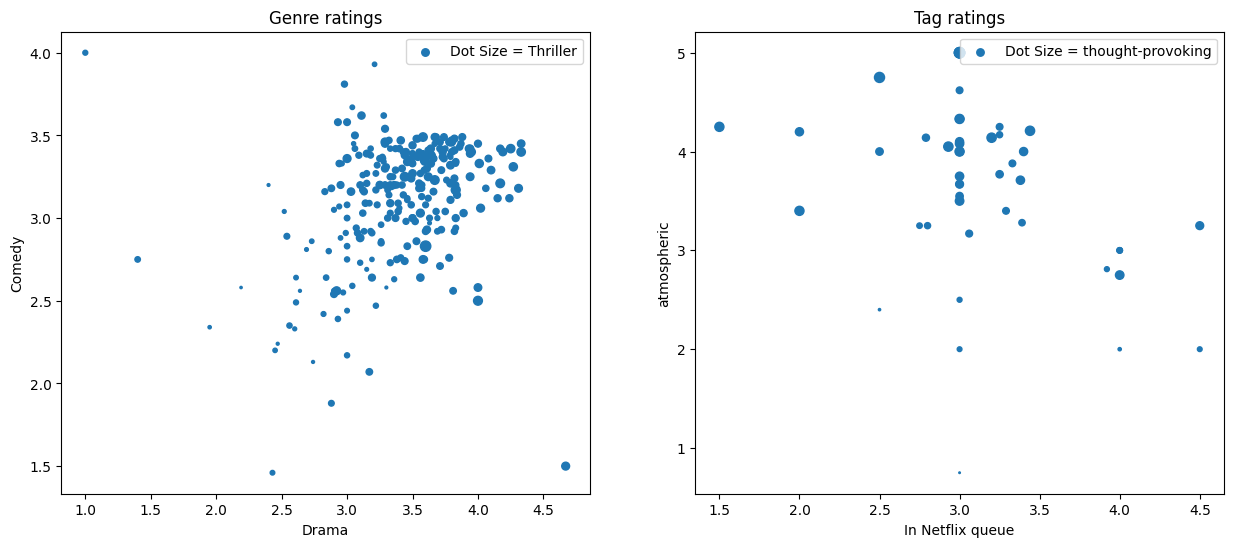

In [15]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax.scatter(genre_ratings_biased['Drama'],genre_ratings_biased['Comedy'], s=genre_ratings_biased['Thriller']**2.5, label='Dot Size = Thriller')
ax.set_xlabel('Drama')
ax.set_ylabel('Comedy')
ax.set_title('Genre ratings')
ax.legend()

ax = fig.add_subplot(122)
ax.scatter(tag_ratings_biased['In Netflix queue'], tag_ratings_biased['atmospheric'], s=tag_ratings_biased['thought-provoking']**2.5, label = 'Dot Size = thought-provoking')
ax.set_xlabel('In Netflix queue')
ax.set_ylabel('atmospheric')
ax.set_title('Tag ratings')
ax.legend()

plt.show()


### Training and test set separiation

In [16]:
#dividing the data into training and test set by 80% and 20% respectively

movies_train = genre_ratings_biased.sample(frac=0.8, random_state=0)
movies_test = genre_ratings_biased.drop(movies_train.index)

tags_train = tag_ratings_biased.sample(frac=0.8, random_state=0)
tags_test = tag_ratings_biased.drop(tags_train.index)

# Clustering

In [17]:
#TODO PROSEGUO DA QUI CON CODE CLEANING...
from sklearn.cluster import KMeans, Birch, MiniBatchKMeans, AffinityPropagation , MeanShift, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


clustering_methods = [KMeans, Birch, MiniBatchKMeans, AffinityPropagation , 
                      MeanShift, AgglomerativeClustering, SpectralClustering] 

model_names = ['KMeans', 'Birch', 'MiniBatchKMeans', 'MeanShift', 'AffinityPropagation', 'Agglomerative', 'Spectral']

In [97]:
def plot_clusters_3d(X, Y, predictions, genre_k, tag_k):
    
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X['Drama'],X['Comedy'],X['Thriller'], c=predictions[0].labels_, cmap='tab10')
    ax.set_xlabel('Sci-Fi')
    ax.set_ylabel('Romance')
    ax.set_zlabel('Adventure')
    ax.set_title('Clusters by favourite genres with K = ' + str(genre_k))

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(Y['In Netflix queue'], Y['atmospheric'], Y['thought-provoking'], c=predictions[1].labels_, cmap='tab10')
    ax.set_xlabel('Funny')
    ax.set_ylabel('Fantasy')
    ax.set_zlabel('Mafia')
    ax.set_title('Clusters by favourite tags with K = ' + str(tag_k))

    plt.show()

In [19]:
def Cluster_data(data, n_clusters, cluster_function):
    X = data.copy()
    X = X.drop('userId', axis=1)
    if(cluster_function in [MeanShift, AffinityPropagation, SpectralClustering]):
        cluster = cluster_function()
    else:
        cluster = cluster_function(n_clusters=n_clusters)
    predictions = cluster.fit_predict(X)
    return cluster

In [20]:
#function to plot silhouette score for different number of clusters and different clustering methods
def silhouette_score_plot(data, method, title):
    trials = 1

    mean_genre_score = []
    for trial in range(trials):
        genre_score = []
        for i in range(2, 20):
            X = data[0].copy()
            X = X.drop('userId', axis=1)
            model = method(n_clusters=i)
            labels = model.fit_predict(X)
            genre_score.append(silhouette_score(X, labels))
        mean_genre_score.append(genre_score)

    mean_genre_score = np.mean(mean_genre_score, axis=0)    

    best_genre_K = np.argmax(mean_genre_score) + 2
    if best_genre_K == 2:
        best_genre_K = 3

    mean_tag_score = []
    for trial in range(trials):
        tag_score = []    
        for i in range(2, 20):
            X = data[1].copy()
            X = X.drop('userId', axis=1)
            model = method(n_clusters=i)
            labels = model.fit_predict(X)
            #compute silhouette score for tags
            tag_score.append(silhouette_score(X, labels))
        mean_tag_score.append(tag_score)

    mean_tag_score = np.mean(mean_tag_score, axis=0)     

    best_tag_K = np.argmax(mean_tag_score) + 2
    if best_tag_K == 2:
        best_tag_K = 3

    #plot silhouette score
    _ , ax = plt.subplots(ncols=2, nrows=1, figsize=(15,3))

    ax[0].plot(range(2, 20), mean_genre_score)
    ax[0].set_title('Silhouette score for genres')
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('Silhouette score')
    ax[0].grid()
    ax[1].plot(range(2, 20), mean_tag_score)
    ax[1].set_title('Silhouette score for tags')
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouette score')
    ax[1].grid()
    plt.suptitle(title)
    plt.show()

    return best_genre_K, best_tag_K

In [21]:
def elbow_method(data, method, title):
    X = data[0].copy()
    X = X.drop('userId', axis=1)
    wcss = []
    for i in range(1, 20):
        model = method(n_clusters=i)
        model.fit(X)
        wcss.append(model.inertia_)

    Y = data[1].copy()
    Y = Y.drop('userId', axis=1)
    wcss_tag = []
    for i in range(1, 20):
        model = method(n_clusters=i)
        model.fit(Y)
        wcss_tag.append(model.inertia_)
    
    _ , ax = plt.subplots(ncols=2, nrows=1, figsize=(15,3))
    ax[0].plot(range(1, 20), wcss)
    ax[0].set_title('Elbow method for genres')
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')
    ax[0].grid()
    ax[1].plot(range(1, 20), wcss_tag)
    ax[1].set_title('Elbow method for tags')
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('WCSS')
    ax[1].grid()
    plt.suptitle(title)
    plt.show()

For algorithms that requires to select the numebr of clusters, I plotted the silhouette score (the higher the better) for some values of K to choose the best number of clusters. I additionally employed the graphical Elbow method for K-means and MiniBatchKMeans to make a better decision.

## KMeans Clustering algorithm                                                            

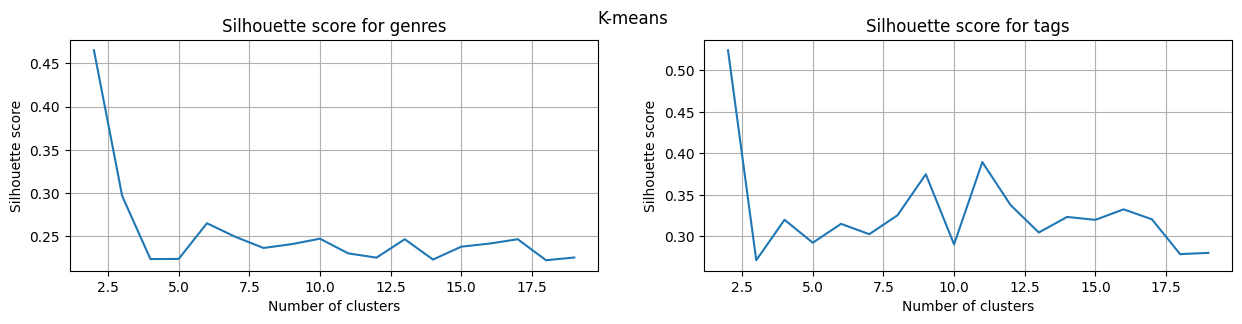

In [22]:
#optimization of K for KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], KMeans,'K-means')

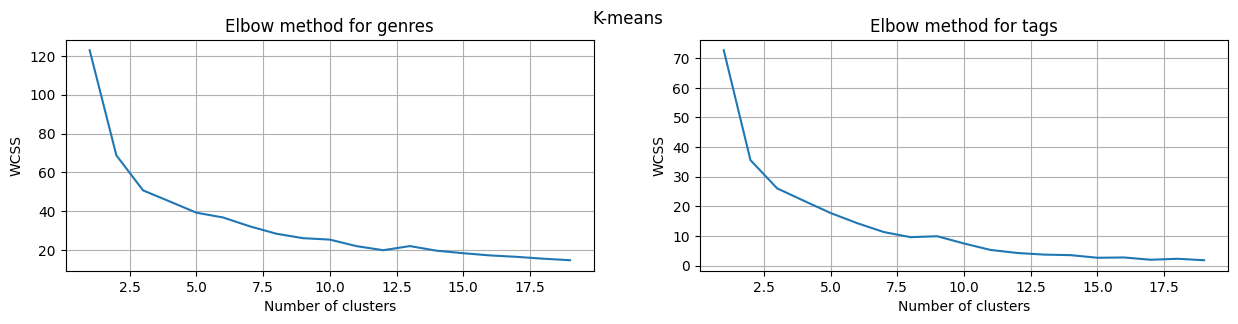

In [23]:
elbow_method([movies_train,tags_train], KMeans, 'K-means')

Both Silhouette score and Elbow method shows that the best number of clusters is 3. While for the first method the choice is clear, for the second one it is not so clear, as the elbow is not very well defined. However, we select 3 clusters for the KMeans algorithm.

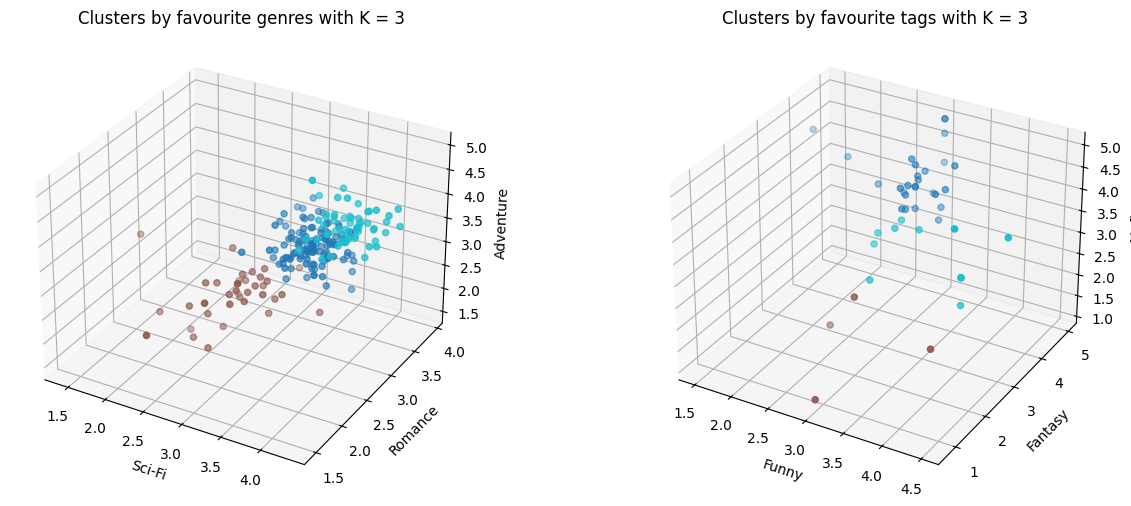

In [24]:
#Apply KMeans clustering by favourite genres and tags with K found before
genre_model_kmean = Cluster_data(movies_train, genre_k, KMeans)

tag_model_kmean = Cluster_data(tags_train, tag_K, KMeans)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_kmean,tag_model_kmean], genre_k, tag_K)


## Birch Clustering Algorithm

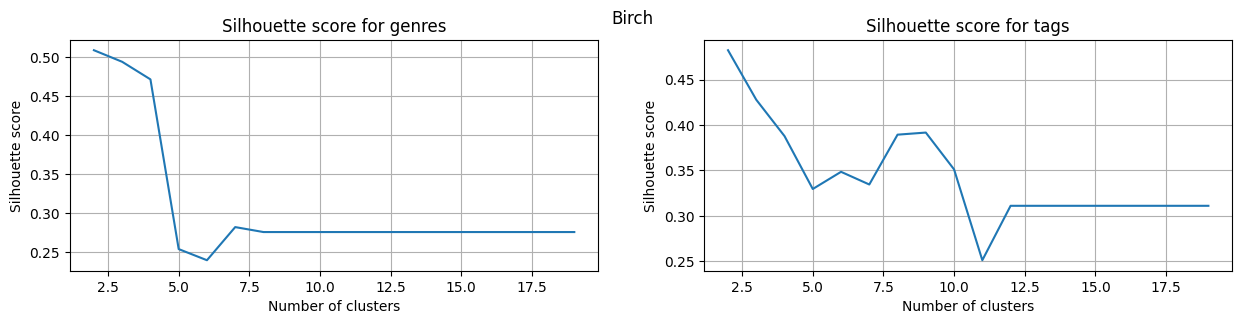

In [25]:
#optimization of K for Birch clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], Birch,'Birch')

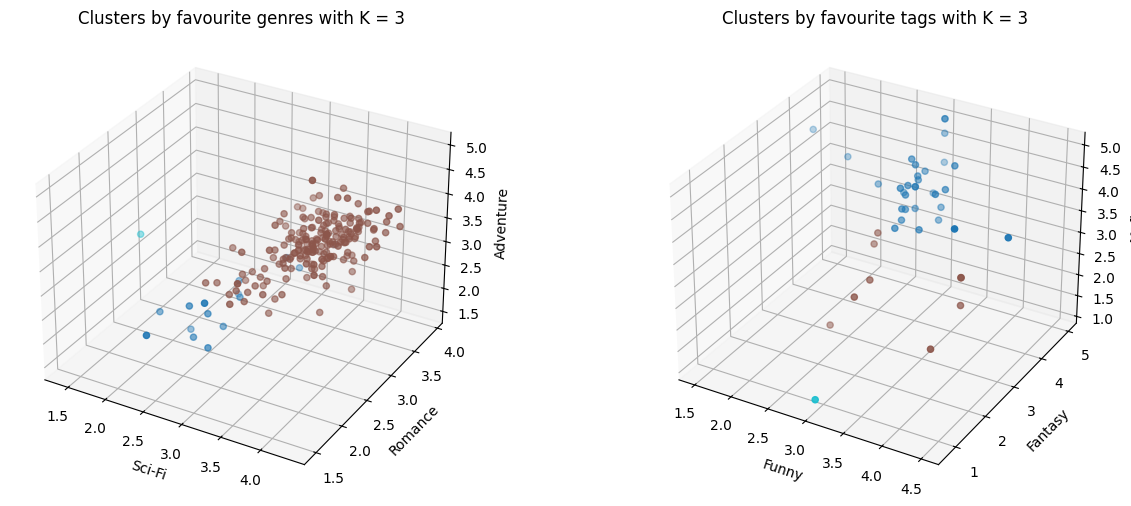

In [26]:
#implementation of Birch clustering by favourite genres
genre_model_birch = Cluster_data(movies_train, genre_k, Birch)

#implementation of Birch clustering by favourite tag
tag_model_birch = Cluster_data(tags_train, tag_K, Birch)


#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_birch,tag_model_birch],genre_k, tag_K)

## Mini-Batch K-Means Clustering

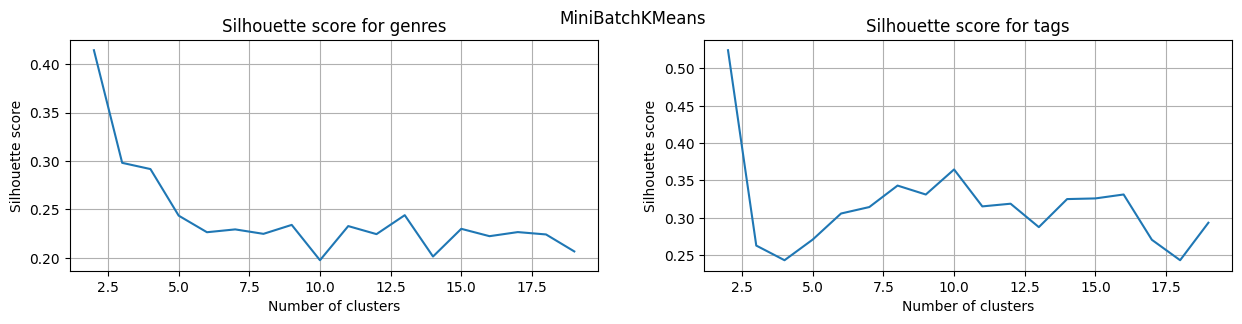

In [27]:
#optimization of K for Minibatch KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], MiniBatchKMeans,'MiniBatchKMeans')

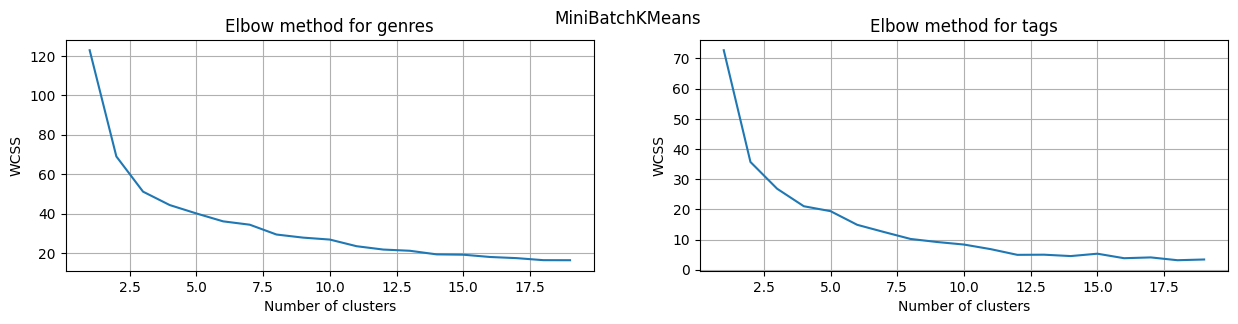

In [28]:
elbow_method([movies_train,tags_train], MiniBatchKMeans, 'MiniBatchKMeans')

As for Kmeans, Silhouette score and Elbow method shows that the best number of clusters is 3. Also in this case the second method is not so clear, as the elbow is not very well defined. However, we select 3 clusters for the KMeans algorithm.

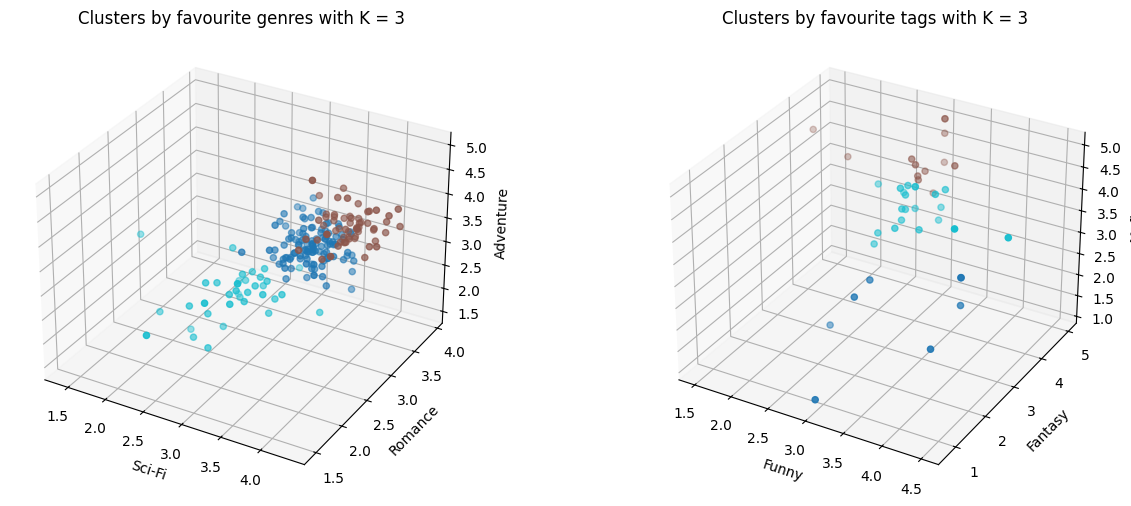

In [29]:
#implementation of MiniBatchKMeans clustering by favourite genres
genre_model_minibatcheskmeans = Cluster_data(movies_train, genre_k, MiniBatchKMeans)

#implementation of MiniBatchKMeans clustering by favourite tags
tag_model_minibatcheskmeans = Cluster_data(tags_train, tag_K, MiniBatchKMeans)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_minibatcheskmeans,tag_model_minibatcheskmeans],genre_k, tag_K)

## Mean-Shift Clustering

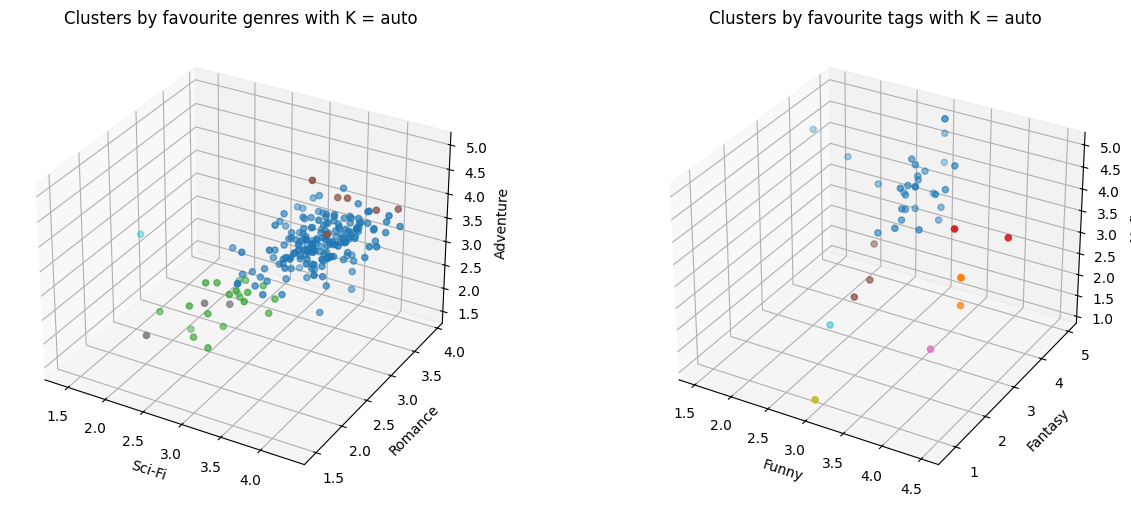

In [30]:
#implementation of MeanShift clustering by favourite genres
genre_model_meanshift = Cluster_data(movies_train, 3, MeanShift)

#implementation of MeanShift clustering by favourite tags
tag_model_meanshift = Cluster_data(tags_train, 3, MeanShift)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_meanshift,tag_model_meanshift], 'auto' , 'auto')

## Affinity Propagation Clustering

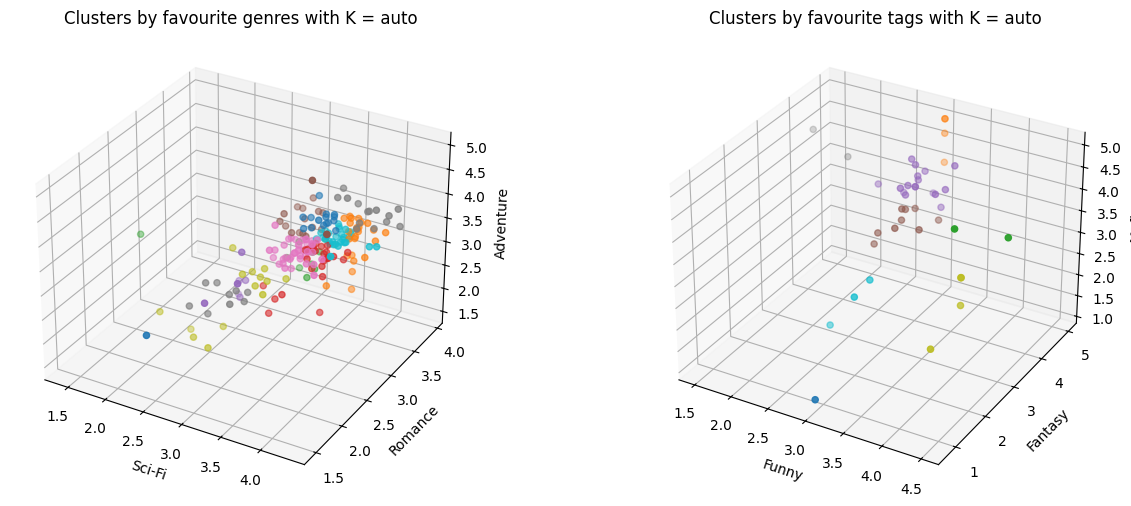

In [31]:
#implementation of AffinityPropagation clustering by favourite genres
genre_model_affinity = Cluster_data(movies_train, 3, AffinityPropagation)

#implementation of AffinityPropagation clustering by favourite tags
tag_model_affinity = Cluster_data(tags_train, 7, AffinityPropagation)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_affinity,tag_model_affinity], 'auto' , 'auto')

## Agglomerative Clustering

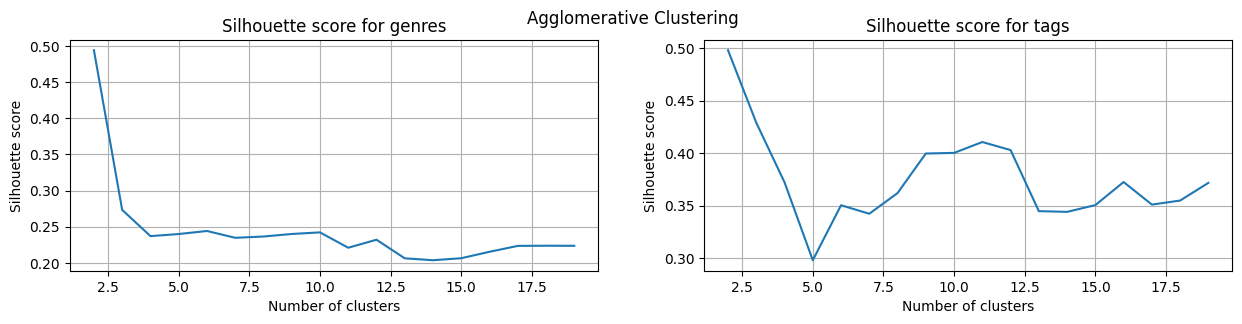

In [32]:
#optimization of K for Agglomerative KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], AgglomerativeClustering,'Agglomerative Clustering')

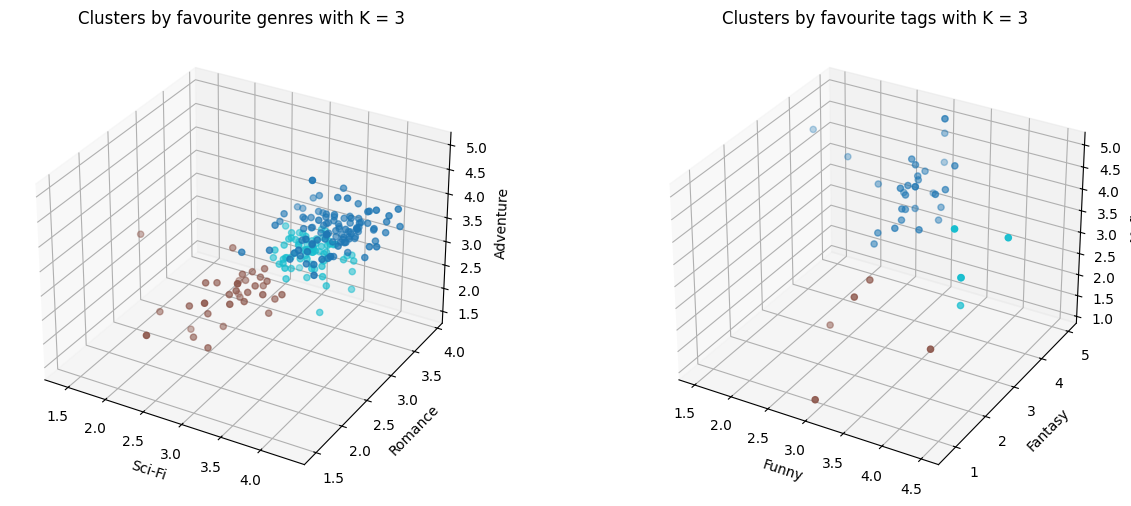

In [33]:
#implementation of AgglomerativeClustering clustering by favourite genres
genre_model_agglomerative = Cluster_data(movies_train, genre_k, AgglomerativeClustering)

#implementation of AgglomerativeClustering clustering by favourite tags
tag_model_agglomerative = Cluster_data(tags_train, tag_K, AgglomerativeClustering)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_agglomerative,tag_model_agglomerative], genre_k, tag_K)

## Spectral Clustering

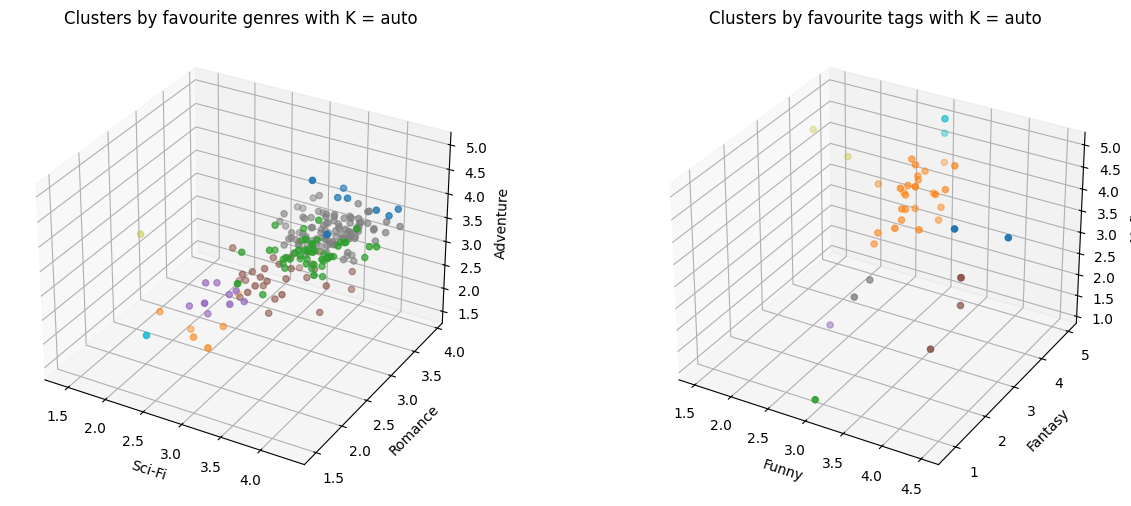

In [34]:
#implementation of SpectralClustering clustering by favourite genres
genre_model_spectral = Cluster_data(movies_train, 3, SpectralClustering)

#implementation of SpectralClustering clustering by favourite tags
tag_model_spectral  = Cluster_data(tags_train, 3, SpectralClustering)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_spectral,tag_model_spectral], 'auto', 'auto')

# Evaluation of performance for the 7 clustering models

In [35]:
genre_models = [genre_model_kmean, genre_model_birch, genre_model_minibatcheskmeans, genre_model_meanshift, genre_model_affinity, genre_model_agglomerative, genre_model_spectral]
tag_models = [tag_model_kmean, tag_model_birch, tag_model_minibatcheskmeans, tag_model_meanshift, tag_model_affinity, tag_model_agglomerative, tag_model_spectral]
model_names = ['KMeans', 'Birch', 'MiniBatchKMeans', 'MeanShift', 'AffinityPropagation', 'Agglomerative', 'Spectral']

In [36]:
# I used the mean of each cluster datapoints as centroids to have uniformity between different 
# models since some of them don't have the 'centroids' attribute incorporated in their class

def get_centroids(data, model):
    centroids = []
    predictions = model.labels_
    number_of_clusters = len(set(model.labels_))
    for i in range(number_of_clusters):
        cluster = data[predictions == i]
        cluster = cluster.drop('userId', axis=1)
        cluster = cluster.mean()
        centroids.append(cluster.values)            
    return centroids

In [37]:
# ausiliary function to predic new data_point clusters for agglomerative 
# and spectral clustering which do not have a proper prediction method

def pseudo_predict_new_data(test_data, train_data, model):
    predictions = []
    for index, row in test_data.iterrows():
        min_distance = float('inf')
        cluster_id = -1
        for i in range(len(set(model.labels_))):
            distance = np.linalg.norm(row[1:] - get_centroids(train_data,model)[i])
            if distance < min_distance:
                min_distance = distance
                cluster_id = i
        predictions.append(model.labels_[cluster_id])
    return predictions

In [38]:
#Function to predict new data point clusters for different models

def predict_new_data(test_data, model,train_data, model_name):
    X = test_data.copy()
    X = X.drop('userId', axis=1)
    if(model_name in['Agglomerative', 'Spectral']):
        predictions = pseudo_predict_new_data(test_data, train_data, model)
    else:
        predictions = model.predict(X)
    return predictions

In [39]:
def plot_results(model_names, genre_criteria, tag_criteria, max_index, title, y_label):

    color = (0.1, 0.2, 0.5, 0.3)
    highest_bar_color = 'green'
    fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(15,5))
    ax[0].bar(model_names, genre_criteria, color = color)
    ax[0].set_ylabel(y_label)
    ax[0].set_title(f'{title} genre')
    ax[0].set_xticklabels(model_names, rotation=45)
    bars = ax[0].get_children() 
    bars[max_index[0]].set_color(highest_bar_color)

    ax[1].bar(model_names, tag_criteria, color = color)
    ax[1].set_ylabel(y_label)
    ax[1].set_title(f'{title} tag')
    ax[1].set_xticklabels(model_names, rotation=45)
    bars = ax[1].get_children() 
    bars[max_index[1]].set_color(highest_bar_color)

    plt.show()

## 1) Clustering Evaluation

### Dunn's Index

In [40]:
#a function to calculate the Dunn index for different existing clustering models
def calculate_Dunn_index(data, model):
    centroids = []
    predictions = model.labels_
    number_of_clusters = len(set(model.labels_))
    centroids = get_centroids(data, model)
    min_distance = float('inf')
    for i in range(number_of_clusters):
        for j in range(i+1, number_of_clusters):
            distance = np.linalg.norm(centroids[i] - centroids[j])
            if distance < min_distance:
                min_distance = distance
    max_distance = 0
    for i in range(number_of_clusters):
        for j in range(len(data)):
            if predictions[j] == i:
                distance = np.linalg.norm(data.iloc[j].drop('userId').values - centroids[i])
                if distance > max_distance:
                    max_distance = distance
    return min_distance/max_distance

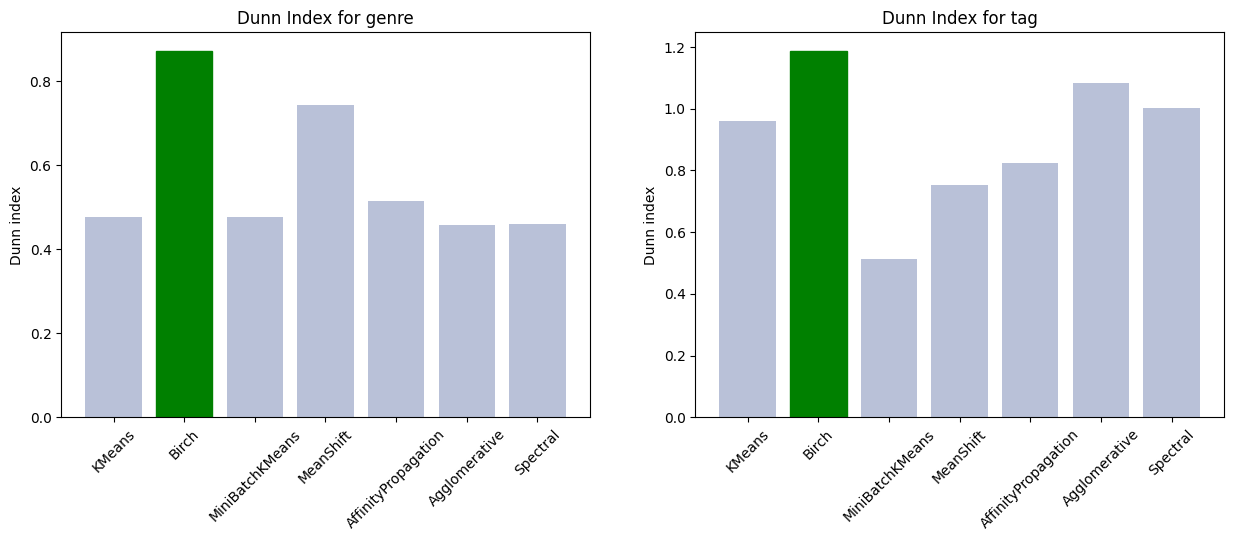

In [41]:
genre_Dunn = []
for i in range(len(genre_models)):
    genre_Dunn.append(calculate_Dunn_index(movies_train, genre_models[i]))
best_genre = genre_Dunn.index(max(genre_Dunn))

tag_Dunn = []
for i in range(len(tag_models)):
    tag_Dunn.append(calculate_Dunn_index(tags_train, tag_models[i]))
best_tag = tag_Dunn.index(max(tag_Dunn))

plot_results(model_names, genre_Dunn, tag_Dunn, [best_genre, best_tag], 'Dunn Index for', 'Dunn index')

### Avarage Similarity

In [42]:
def cosine_similarity(v1, v2):
  v1_norm = np.linalg.norm(v1)
  v2_norm = np.linalg.norm(v2)
  if v1_norm * v2_norm == 0:
    return 0
  return np.abs(np.dot(v1, v2)) / (v1_norm * v2_norm)


In [43]:
def average_similarity_between_clusters(data, cluster_labels, cluster1, cluster2):

  cluster1_data = data[cluster_labels == cluster1]
  cluster2_data = data[cluster_labels == cluster2]


  similarities = []
  for data1 in cluster1_data:
    for data2 in cluster2_data:
      similarities.append(cosine_similarity(data1, data2))

  if not similarities:
    return 0

  return np.mean(similarities)


In [44]:
 #compute the average similarity between clusters for every pair of clusters and then avarage them
def average_similarity(data, model):
  cluster_similarities = []
  labels = model.labels_
  for cluster1 in range(len(set(labels))):
    for cluster2 in range(cluster1+1, len(set(labels))):
      if cluster1 != cluster2:
        cluster_similarities.append(average_similarity_between_clusters(data, labels, cluster1, cluster2))
  return np.mean(cluster_similarities)

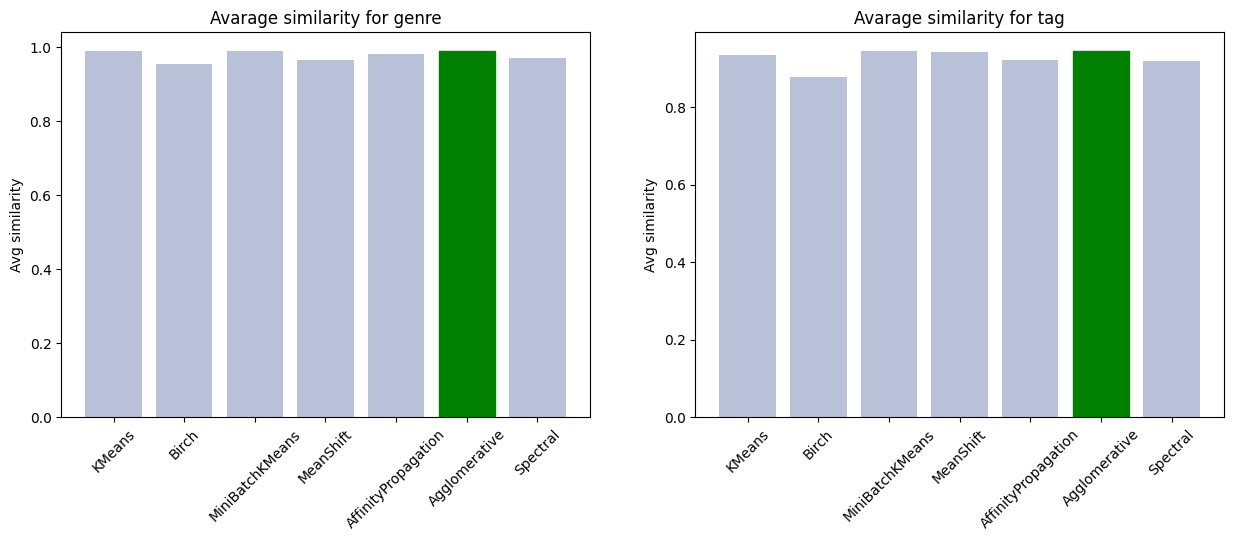

In [45]:
genre_similarities = []
for i in range(len(genre_models)):
    genre_similarities.append(average_similarity(movies_train.drop('userId', axis=1).values, genre_models[i]))
best_genre = genre_similarities.index(max(genre_similarities))

tag_similarities = []
for i in range(len(tag_models)):
    tag_similarities.append(average_similarity(tags_train.drop('userId', axis= 1).values, tag_models[i]))
best_tag = tag_similarities.index(max(tag_similarities))

plot_results(model_names, genre_similarities, tag_similarities, [best_genre, best_tag], 'Avarage similarity for', 'Avg similarity')

### Davies-Bouldin Index

In [46]:
def davies_bouldin_index(data, model):
    centroids = get_centroids(data, model)
    labels = model.labels_
    number_of_clusters = len(set(labels))
    cluster_distances = []
    for i in range(number_of_clusters):
        distances = []
        for j in range(number_of_clusters):
            if i != j:
                distance = np.linalg.norm(centroids[i] - centroids[j])
                intra_cluster_distance = []
                for k in range(len(data)):
                    if labels[k] == i:
                        intra_cluster_distance.append(np.linalg.norm(data.iloc[k].drop('userId').values - centroids[i]))
                avg_intra_cluster_distance = np.mean(intra_cluster_distance)
                distances.append((avg_intra_cluster_distance + np.mean([np.linalg.norm(centroids[i] - centroids[j])])) / distance)
        cluster_distances.append(max(distances))
    return np.mean(cluster_distances)

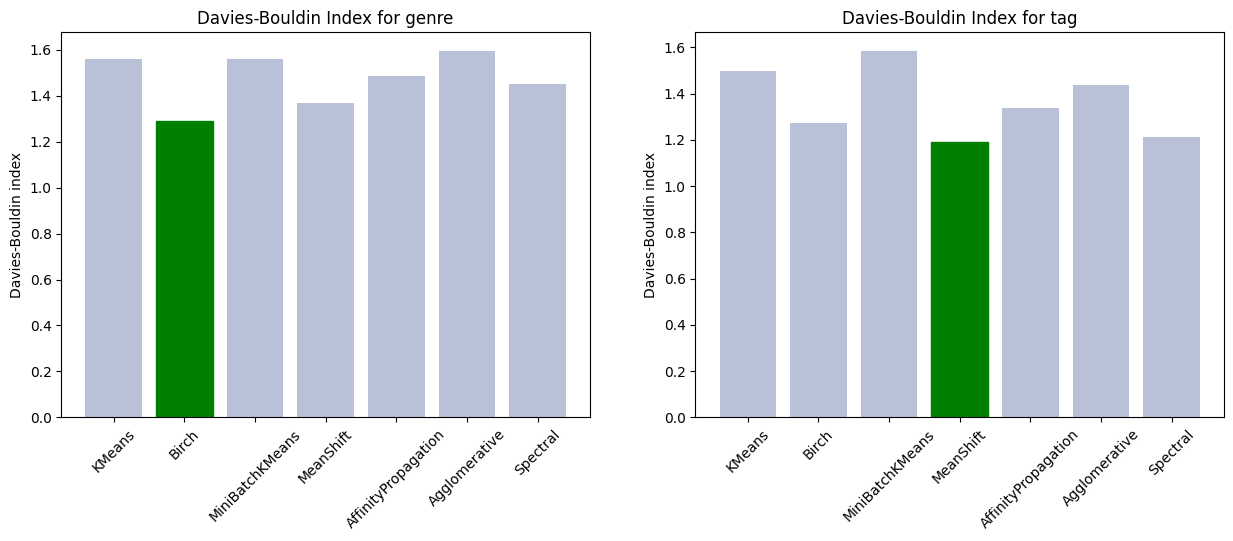

In [47]:
genre_davies_bouldin = []
for i in range(len(genre_models)):
    genre_davies_bouldin.append(davies_bouldin_index(movies_train, genre_models[i]))
best_genre = genre_davies_bouldin.index(min(genre_davies_bouldin))

tag_davies_bouldin = []
for i in range(len(tag_models)):
    tag_davies_bouldin.append(davies_bouldin_index(tags_train, tag_models[i]))
best_tag = tag_davies_bouldin.index(min(tag_davies_bouldin))

plot_results(model_names, genre_davies_bouldin, tag_davies_bouldin, [best_genre, best_tag], 'Davies-Bouldin Index for', 'Davies-Bouldin index')

### Calinski-Harabasz Index

In [48]:
def calinski_harabasz_index(data, model):
    centroids = get_centroids(data, model)
    labels = model.labels_
    number_of_clusters = len(set(labels))
    cluster_variances = []
    for i in range(number_of_clusters):
        cluster_variance = []
        for j in range(len(data)):
            if labels[j] == i:
                cluster_variance.append(np.linalg.norm(data.iloc[j].drop('userId').values - centroids[i]))
        cluster_variances.append(np.mean(cluster_variance))
    return np.sum(cluster_variances) / np.sum([np.linalg.norm(data.iloc[i].drop('userId').values - centroids[model.labels_[i]]) for i in range(len(data))])

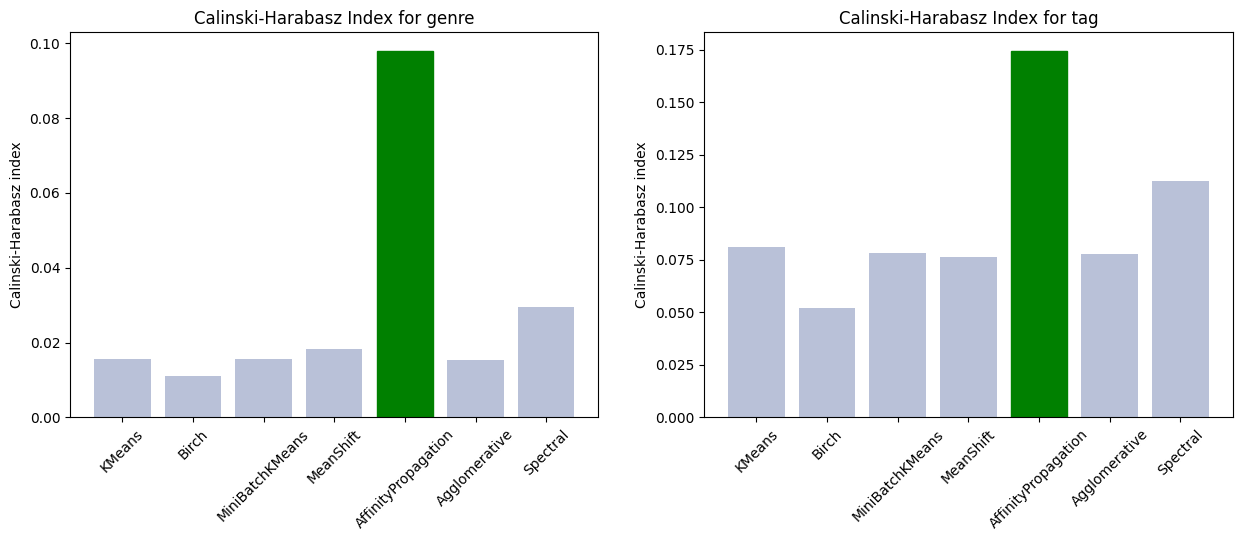

In [49]:
genre_calinski_harabasz = []
for i in range(len(genre_models)):
    genre_calinski_harabasz.append(calinski_harabasz_index(movies_train, genre_models[i]))
best_genre = genre_calinski_harabasz.index(max(genre_calinski_harabasz))

tag_calinski_harabasz = []
for i in range(len(tag_models)):
    tag_calinski_harabasz.append(calinski_harabasz_index(tags_train, tag_models[i]))
best_tag = tag_calinski_harabasz.index(max(tag_calinski_harabasz))

plot_results(model_names, genre_calinski_harabasz, tag_calinski_harabasz, [best_genre, best_tag], 'Calinski-Harabasz Index for', 'Calinski-Harabasz index') 

### Computational Time

In [50]:
def evaluate_models(data, clustering_methods):
    results = []
    for method in clustering_methods:
        start = time.time()
        Cluster_data(data, 3, method)
        end = time.time()
        results.append((end-start)*1000)
    return results

genre_results = evaluate_models(movies_train, clustering_methods)
best_genre = genre_results.index(min(genre_results))
tag_results = evaluate_models(tags_train, clustering_methods)
best_tag = tag_results.index(min(tag_results))

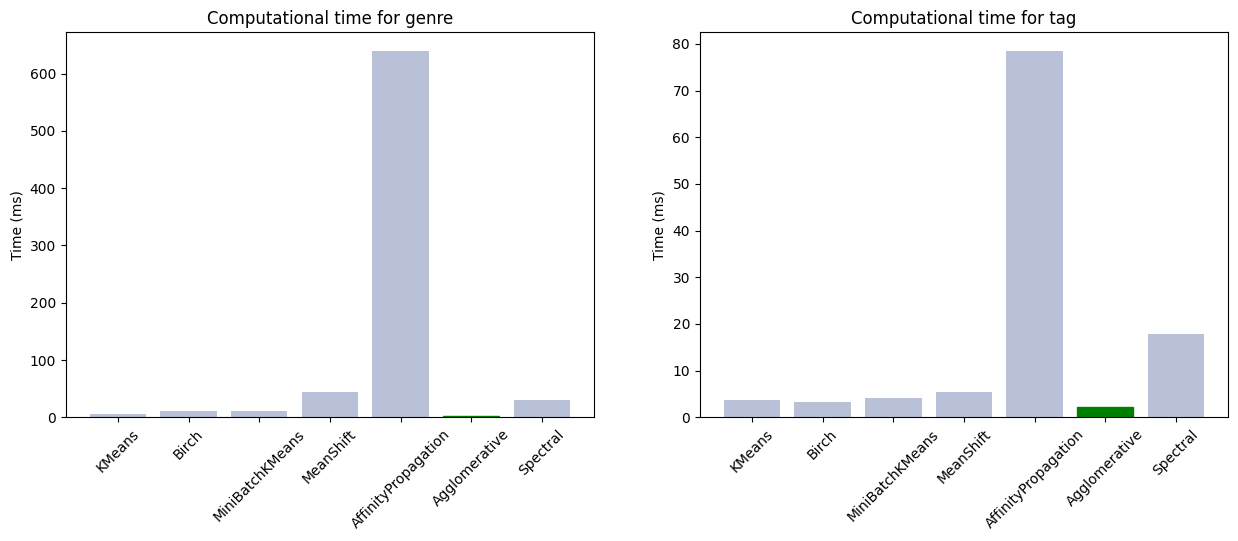

In [51]:
plot_results(model_names, genre_results, tag_results, [best_genre, best_tag], 'Computational time for', 'Time (ms)')

## 2) Recommendation System evaluation

In [52]:
# Function that predict the movie ratings of a user of the test set based on the avarage movie ratings 
# within the user's assigned cluster in order to assess the performance of the recommendation system
# by comparing the predicted ratings with the actual ratings.

def predict_ratings(test_set, train_set, user_id, model, model_name):
    if(user_id in test_set['userId'].values):
        X = test_set.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = predict_new_data(test_set, model, train_set, model_name)[new_user]
        cluster_ids = train_set[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == user_id]
    else:
        print('User not found in Test set, please try another user...')
        return
    predicted_ratings = ratings[ratings['userId'].isin(cluster_ids) & ratings['movieId'].isin(user_rated_movies['movieId'])].drop('userId', axis=1).groupby('movieId').mean()
    return predicted_ratings.reset_index() , cluster_ids

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


def evaluate_recommender(test_set, train_set, k, model, model_name, threshold=3):
    actual_ratings = []
    predicted_ratings = []
    precisions = []
    
    for user_id in test_set['userId'].unique():
        predicted, cluster_ids = predict_ratings(test_set, train_set, user_id, model, model_name) 
        actual = ratings[ratings['userId'] == user_id]
        actual = actual[actual['movieId'].isin(predicted['movieId'])].drop('userId' , axis=1) 

        actual_ratings.append(list(actual['rating']))
        predicted_ratings.append(list(predicted['rating']))

        top_N_predicted = predicted.sort_values('rating', ascending=False).head(k)
        relevant_items = actual[actual['rating'] >= threshold]['movieId']
        
        precision = len(relevant_items[relevant_items.isin(top_N_predicted['movieId'])]) / k
        precisions.append(precision)
        
    
    actual_ratings = [rating for sublist in actual_ratings for rating in sublist]
    predicted_ratings = [rating for sublist in predicted_ratings for rating in sublist]
    actual_ratings = np.array(actual_ratings)
    predicted_ratings = np.array(predicted_ratings)

    mae = mean_absolute_error(actual_ratings, predicted_ratings)
    rmse = mean_squared_error(actual_ratings, predicted_ratings, squared=False)
    avg_precision = np.mean(precisions)
    return mae, rmse, avg_precision

In [54]:
genre_recommender_results = [evaluate_recommender(movies_test, movies_train, 5, genre_models[i], model_names[i]) for i in range(len(genre_models))]

tag_recommender_results = [evaluate_recommender(tags_test, tags_train, 5, tag_models[i], model_names[i]) for i in range(len(genre_models))]

genre_recommender_results = np.array(genre_recommender_results)
tag_recommender_results = np.array(tag_recommender_results)

best_genre_mae = genre_recommender_results[:,0].argmin()
best_genre_rmse = genre_recommender_results[:,1].argmin()
best_genre_precision = genre_recommender_results[:,2].argmax()

best_tag_mae = tag_recommender_results[:,0].argmin()
best_tag_rmse = tag_recommender_results[:,1].argmin()
best_tag_precision = tag_recommender_results[:,2].argmax()

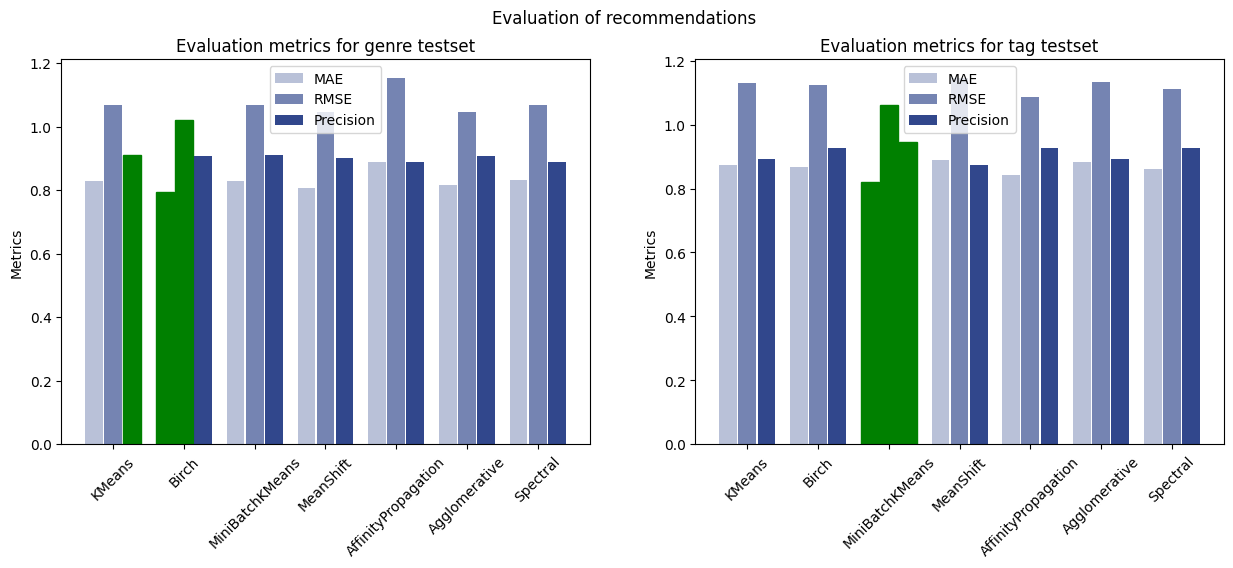

In [55]:
def plot_multiple_results(model_names, genre_criteria, tag_criteria, best_genre, best_tag, title, y_label):

    color1 = (0.1, 0.2, 0.5, 0.3)
    color2 = (0.1, 0.2, 0.5, 0.6)
    color3 = (0.1, 0.2, 0.5, 0.9)

    highest_bar_color = 'green'

    x = np.arange(len(model_names))
    width = 0.25

    fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(15,5))
    rects1 = ax[0].bar(x - (width+0.02), genre_criteria[:,0], width, label='MAE', color = color1)
    rects2 = ax[0].bar(x, genre_criteria[:,1], width, label='RMSE', color = color2)
    rects3 = ax[0].bar(x + (width+0.02), genre_criteria[:,2], width, label='Precision', color = color3)
    ax[0].set_ylabel(y_label)
    ax[0].set_title(f'{title} genre testset')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(model_names, rotation=45)
    ax[0].legend()
    bars = ax[0].get_children()

    bars[best_genre[0]].set_color(highest_bar_color)
    bars[best_genre[1]+len(model_names)].set_color(highest_bar_color)
    bars[best_genre[2]+2*len(model_names)].set_color(highest_bar_color)

    rects1 = ax[1].bar(x - (width+0.02), tag_criteria[:,0], width, label='MAE', color = color1)
    rects2 = ax[1].bar(x, tag_criteria[:,1], width, label='RMSE', color = color2)
    rects3 = ax[1].bar(x + (width+0.02), tag_criteria[:,2], width, label='Precision', color = color3)

    ax[1].set_ylabel(y_label)
    ax[1].set_title(f'{title} tag testset')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(model_names, rotation=45)
    ax[1].legend()
    bars = ax[1].get_children()
    bars[best_tag[0]].set_color(highest_bar_color)
    bars[best_tag[1]+len(model_names)].set_color(highest_bar_color)
    bars[best_tag[2]+2*len(model_names)].set_color(highest_bar_color)

    plt.suptitle('Evaluation of recommendations')
    plt.show()


plot_multiple_results(model_names, genre_recommender_results, tag_recommender_results, [best_genre_mae, best_genre_rmse, best_genre_precision], 
             [best_tag_mae, best_tag_rmse, best_tag_precision], 'Evaluation metrics for', 'Metrics')


# Conclusion

Considering the overall performances for different metrics, the best clustering algorithm using movies's genres as clustering dimensions is Birch which has the best clustering results and also high recommendations quality 

For tags the result is not so clear, the best clustering algorithm is Agglomerative Clustering which has good clustering results but the recommendations quality is not the highest. On the other hand Mini-Batch K-Means has the highest recommendations quality.

# Top N Movies

In [56]:
#Function that returns the top N recommended movies for a given user 
def TOP_N_MOVIES(train_set, test_set, model,user_id, N, model_name):
    if(user_id in test_set['userId'].values):
        X = test_set.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = predict_new_data(test_set, model, train_set, model_name)[new_user]
        cluster_ids = train_set[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == test_set.iloc[new_user]['userId']]
    elif(user_id in train_set['userId'].values):
        X = train_set.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = model.labels_[new_user]
        cluster_ids = train_set[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == train_set.iloc[new_user]['userId']]
    else:
        print('User not found in Test or Train set, please try another user...')
        return
    cluster_movies_not_rated = ratings[ratings['userId'].isin(cluster_ids) & ~ratings['movieId'].isin(user_rated_movies['movieId'])].drop('userId', axis=1).groupby('movieId').mean().sort_values('rating', ascending=False).head(N)
    for(index, _) in cluster_movies_not_rated.iterrows():
        cluster_movies_not_rated.at[index, 'title'] = movies[movies['movieId'] == index]['title'].values[0]
    return cluster_movies_not_rated.drop('rating', axis=1).reset_index()


# example of top 10 recommended movies for a user using birch clustering
TOP_N_MOVIES(tags_train, tags_test, tag_model_minibatcheskmeans, 20, 20, 'miniBatchKMeans')

movieId                                              title
0      3819                                     Tampopo (1985)
1     96811                                End of Watch (2012)
2     73881                                    3 Idiots (2009)
3     74226  Dream of Light (a.k.a. Quince Tree Sun, The) (...
4      1884              Fear and Loathing in Las Vegas (1998)
5     55118                            Eastern Promises (2007)
6      1111  Microcosmos (Microcosmos: Le peuple de l'herbe...
7     96821            Perks of Being a Wallflower, The (2012)
8      6482     Dumb and Dumberer: When Harry Met Lloyd (2003)
9      2572                  10 Things I Hate About You (1999)
10    47997                                   Idiocracy (2006)
11     4105                              Evil Dead, The (1981)
12    95167                                       Brave (2012)
13    54999                                Shoot 'Em Up (2007)
14     4256                    Center of the World, The (2001)
15    48304                                  Apocalypto (2006)
16     6807          Monty Python's The Meaning of Life (1983)
17     2379    Police Academy 2: Their First Assignment (1985)
18   101765          Perfect Plan, A (Plan parfait, Un) (2012)
19     2380          Police Academy 3: Back in Training (1986)

# Adding more Dimensions...

My second strategy is to consider all 20 genres and top 20 tags, then perform dimensionality reduction through the use of PRINCIPAL COMPONENT ANALYSIS to extract fundamental relations within the dataset features while reducing their magnitude. Then I will evaluate the performance of the clustering algorithms using the same metrics as before and see if there is any substantial improvement in the clustering and recommendation results.

## Data preparation

In [57]:
#find 20 most popular tags
tag_counts = tags['tag'].value_counts()
tag_counts = tag_counts.head(20)
tag_counts

tag
In Netflix queue      131
atmospheric            36
thought-provoking      24
superhero              24
funny                  23
surreal                23
Disney                 23
religion               22
sci-fi                 21
quirky                 21
dark comedy            21
psychology             21
suspense               20
twist ending           19
visually appealing     19
crime                  19
politics               18
mental illness         16
music                  16
time travel            16
Name: count, dtype: int64

In [58]:
#get a list of all genres
all_genres = []
for genre in movies['genres']:
    all_genres.extend(genre.split('|'))
all_genres = list(set(all_genres))

column_names_genre = all_genres.copy()
column_names_genre.insert(0, 'userId')

In [59]:
#get a list of 20 most popular tags
all_tags = list(tag_counts.index)

column_names_tags = all_tags.copy()
column_names_tags.insert(0, 'userId')

Display raw datapoints

In [60]:
all_genre_ratings = get_genre_ratings(ratings, movies, all_genres, column_names_genre)
all_genre_ratings.head()

userId  Horror  Comedy  Musical  Thriller  Film-Noir   War  Fantasy  \
0     1.0     NaN     NaN      NaN       NaN        NaN   NaN      NaN   
1     2.0    3.47    4.28     4.68      4.15        5.0  4.50     4.30   
2     3.0    3.00    4.00      NaN      3.70        NaN  4.50      NaN   
3     4.0    4.69    1.00     0.50      4.14        NaN  0.50     3.38   
4     5.0    4.25    3.51     4.00      3.55        4.0  3.57     3.68   

   Animation  Romance  ...  Action  Adventure  Documentary  \
0        NaN      NaN  ...     NaN        NaN          NaN   
1       4.69     4.31  ...    4.32       4.39          NaN   
2        NaN     4.50  ...    3.95       4.17         4.33   
3       0.50     0.50  ...    3.57       2.73          NaN   
4       4.00     3.38  ...    3.32       3.66         4.00   

   (no genres listed)  IMAX  Crime  Drama  Mystery  Sci-Fi  Children  
0                 NaN   NaN    NaN    NaN      NaN     NaN       NaN  
1                 NaN   NaN   4.36   4.53     4.17    4.22      4.55  
2                 NaN  3.75   3.80   3.88     4.00    3.88       NaN  
3                 NaN   NaN   0.50   0.75     5.00    4.20      0.50  
4                 NaN  3.00   3.81   3.48     3.48    2.83      3.80  

[5 rows x 21 columns]

In [61]:
all_tags_ratings = get_tag_ratings(ratings, tags, all_tags, column_names_tags)
all_tags_ratings.head()

userId  In Netflix queue  atmospheric  thought-provoking  superhero  funny  \
0     1.0               NaN          NaN                NaN        NaN    NaN   
1     2.0               4.0         3.67               4.50        4.2   4.00   
2     3.0               NaN         4.00               3.67        4.0   3.83   
3     4.0               NaN          NaN               0.50        NaN    NaN   
4     5.0               4.5         2.00               2.67        NaN   2.50   

   surreal  Disney  religion  sci-fi  ...  dark comedy  psychology  suspense  \
0      NaN     NaN       NaN     NaN  ...          NaN         NaN       NaN   
1      5.0    4.62       5.0    4.75  ...          4.6        3.00      3.29   
2      4.0     NaN       NaN    3.50  ...          3.0        4.25      4.00   
3      NaN    0.50       NaN     NaN  ...          NaN        0.50       NaN   
4      2.0    4.20       4.5    3.67  ...          3.0        3.40      3.50   

   twist ending  visually appealing  crime  politics  mental illness  music  \
0           NaN                 NaN    NaN       NaN             NaN    NaN   
1          4.67                 NaN    4.5       5.0             5.0    4.0   
2          4.00                 4.0    4.5       5.0             NaN    4.0   
3           NaN                 NaN    NaN       NaN             NaN    0.5   
4          2.57                 3.0    2.8       4.0             2.0    3.5   

   time travel  
0          NaN  
1         4.33  
2          NaN  
3          NaN  
4         2.00  

[5 rows x 21 columns]

I Fill the empty values of unrated movies with the user's avarage rating for genre and tag dataframes

In [62]:
# compute the avarage rating of each user
user_means = all_genre_ratings.drop('userId', axis=1).mean(axis=1)

#for every row, fill the empty values with the mean of that row
for row in range(len(all_genre_ratings)):
    for column in range(1, len(all_genre_ratings.columns)):
        if pd.isnull(all_genre_ratings.iloc[row, column]):
            all_genre_ratings.iloc[row, column] = user_means[row]
all_genre_ratings = all_genre_ratings.dropna()

In [63]:
# compute the avarage rating of each user
user_means = all_tags_ratings.drop('userId', axis=1).mean(axis=1)

#for every row, fill the empty values with the mean of that row
for row in range(len(all_tags_ratings)):
    for column in range(1, len(all_tags_ratings.columns)):
        if pd.isnull(all_tags_ratings.iloc[row, column]):
            all_tags_ratings.iloc[row, column] = user_means[row]
all_tags_ratings = all_tags_ratings.dropna()

## PCA

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


def compute_pca(data, threshold=0.9):
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Apply PCA
    pca = PCA()
    pca_data = pca.fit_transform(scaled_data)

    # Determine the number of components to explain 90% of the variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)
    n_components = np.argmax(cumulative_explained_variance >= threshold) + 1

    # Transform data with the selected number of components
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)

    return reduced_data

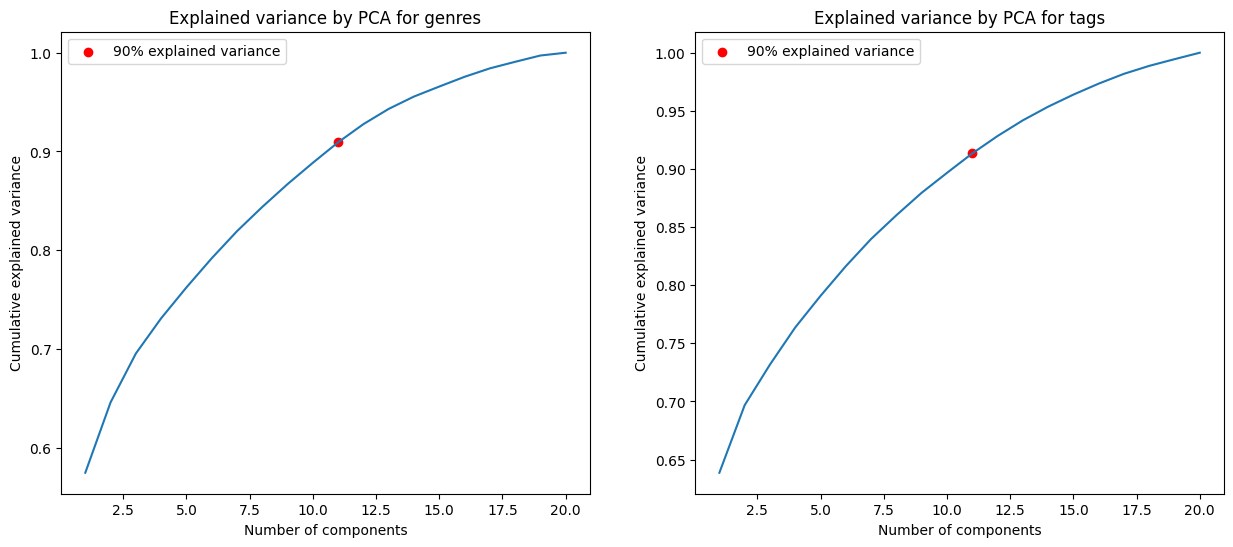

In [65]:
#plot the explained variance for the PCA
def plot_explained_variance(genre_data, tag_data):
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(genre_data)

    pca = PCA()
    pca_data = pca.fit_transform(scaled_data)

    explained_variance_genre = pca.explained_variance_ratio_
    cumulative_explained_variance_genre = np.cumsum(explained_variance_genre)
    n_components_genre = np.argmax(cumulative_explained_variance_genre >= 0.9) + 1

    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(121)
    ax.plot(range(1, len(explained_variance_genre) + 1), cumulative_explained_variance_genre)
    ax.scatter(n_components_genre, cumulative_explained_variance_genre[n_components_genre - 1], c='red', label='90% explained variance')
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Cumulative explained variance')
    ax.set_title('Explained variance by PCA for genres')
    ax.legend()

    scaled_data = scaler.fit_transform(tag_data)

    pca2 = PCA()
    pca_data = pca2.fit_transform(scaled_data)

    explained_variance_tag = pca2.explained_variance_ratio_
    cumulative_explained_variance_tag = np.cumsum(explained_variance_tag)
    n_components_tag = np.argmax(cumulative_explained_variance_tag >= 0.9) + 1

    ax = fig.add_subplot(122)
    ax.plot(range(1, len(explained_variance_tag) + 1), cumulative_explained_variance_tag)
    ax.scatter(n_components_tag, cumulative_explained_variance_tag[n_components_tag - 1], c='red', label='90% explained variance')
    ax.set_xlabel('Number of components')
    ax.set_ylabel('Cumulative explained variance')
    ax.set_title('Explained variance by PCA for tags')
    ax.legend()

#plot the explained variance for the PCA
plot_explained_variance(all_genre_ratings.drop('userId', axis=1), all_tags_ratings.drop('userId', axis=1))

From the above plot we understand that we must select the first 11 components to explain at least 90% of the variance in the data.

## Principal components analysis and visualization of first 2 principal components

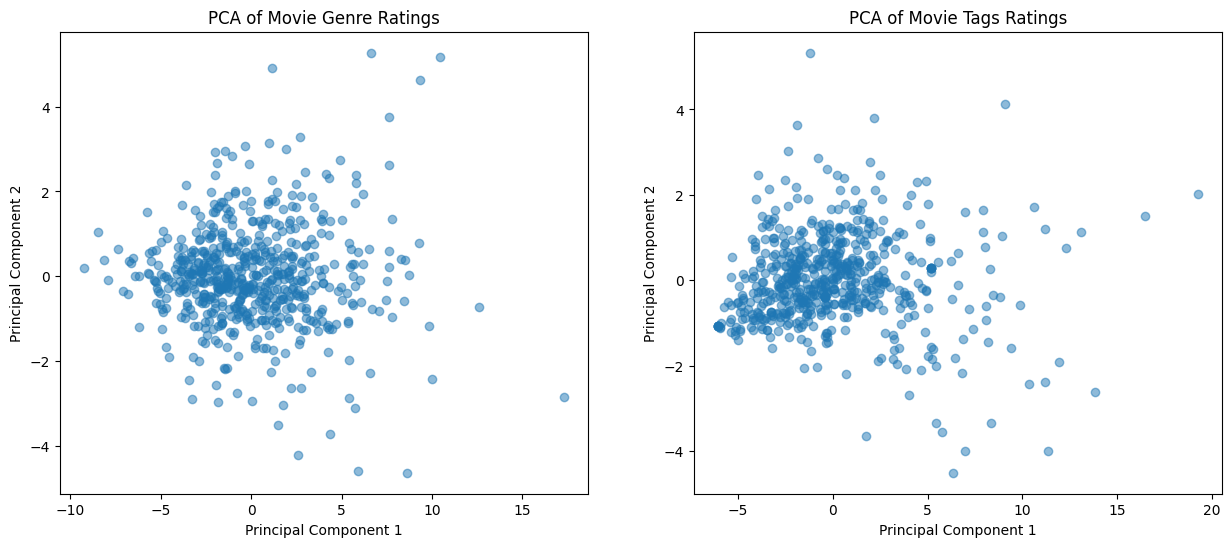

In [66]:
data1 = all_genre_ratings.copy()
genre_ids = data1['userId']
data1 = data1.drop('userId', axis=1)
genre_pca = compute_pca(data1)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax.scatter(genre_pca[:, 0], genre_pca[:, 1], alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA of Movie Genre Ratings')

data1 = all_tags_ratings.copy()
tag_ids = data1['userId']
data1 = data1.drop('userId', axis=1)
tag_pca = compute_pca(data1)

ax = fig.add_subplot(122)
ax.scatter(tag_pca[:, 0], tag_pca[:, 1], alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA of Movie Tags Ratings')

plt.show()

In [67]:
columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11']
genre_pca = pd.concat([pd.DataFrame(genre_ids), pd.DataFrame(genre_pca, columns=columns)], axis=1)
tag_pca = pd.concat([pd.DataFrame(tag_ids), pd.DataFrame(tag_pca, columns=columns)], axis=1)
genre_pca = genre_pca.dropna()
tag_pca = tag_pca.dropna()

Now I will perform the same analysis of top 3 genres/tags, this time using 11 dimension for clustering datapoints

## Training and test set separation

In [68]:
#divide the data into training and test set by 80% and 20% respectively
genre_pca_train = genre_pca.sample(frac=0.8, random_state=0)
genre_pca_test = genre_pca.drop(genre_pca_train.index)

tag_pca_train = tag_pca.sample(frac=0.8, random_state=0)
tag_pca_test = tag_pca.drop(tag_pca_train.index)

In [69]:
 #function to plot first 3 principal components and their relative clusters in 3d
def plot_clusters_3d_pca(X, Y, predictions, genre_k, tag_k):
    
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X['PC1'],X['PC2'],X['PC3'], c=predictions[0].labels_, cmap='tab10')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('Clusters by favourite genres with K = ' + str(genre_k))

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(Y['PC1'], Y['PC2'], Y['PC3'], c=predictions[1].labels_, cmap='tab10')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('Clusters by favourite tags with K = ' + str(tag_k))

    plt.show()

# Clustering dataset with 7 algorithms

## K-means

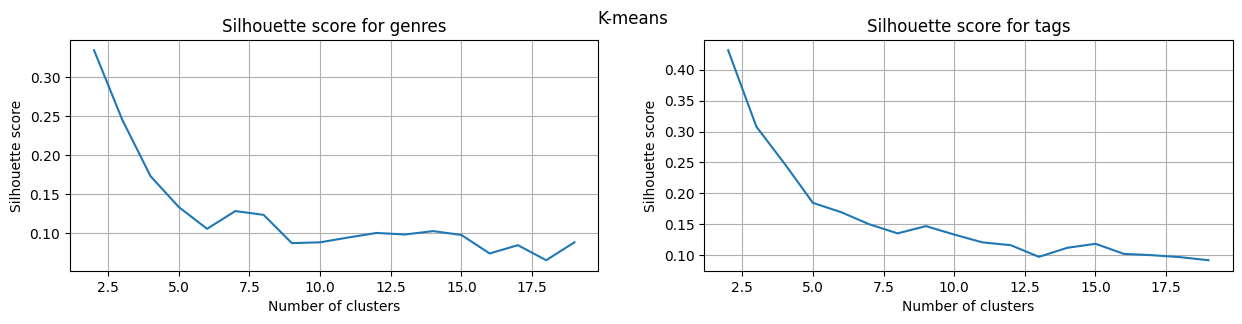

In [70]:
#optimization of K for KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([genre_pca_train,tag_pca_train], KMeans,'K-means')

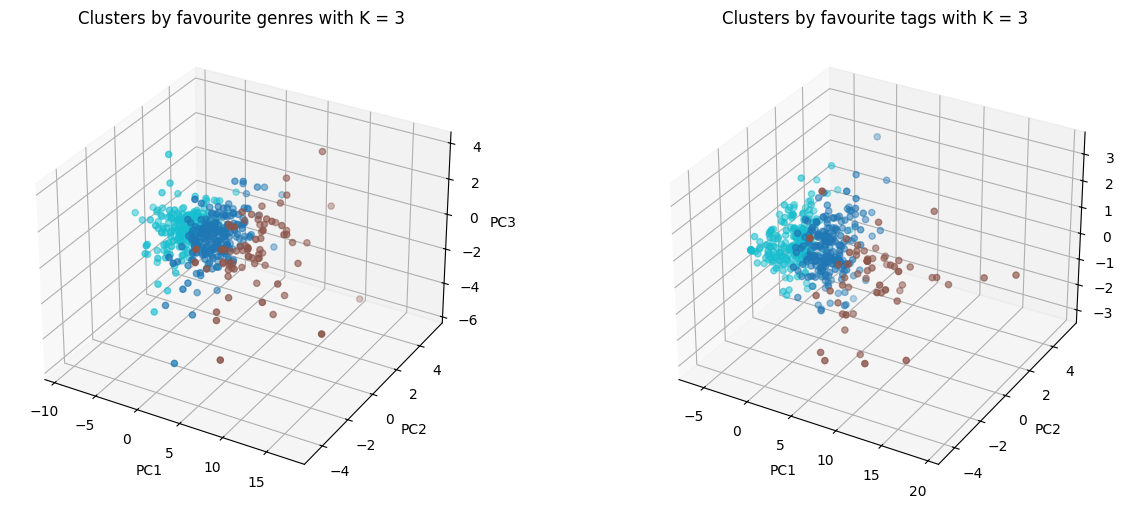

In [71]:
#Apply KMeans clustering by favourite genres and tags with K found before
genre_model_kmean_pca = Cluster_data(genre_pca_train, genre_k, KMeans)

tag_model_kmean_pca = Cluster_data(tag_pca_train, tag_K, KMeans)

#plot the clusters for first 3 principal components
plot_clusters_3d_pca(genre_pca_train, tag_pca_train, [genre_model_kmean_pca,tag_model_kmean_pca], genre_k, tag_K)

## Birch

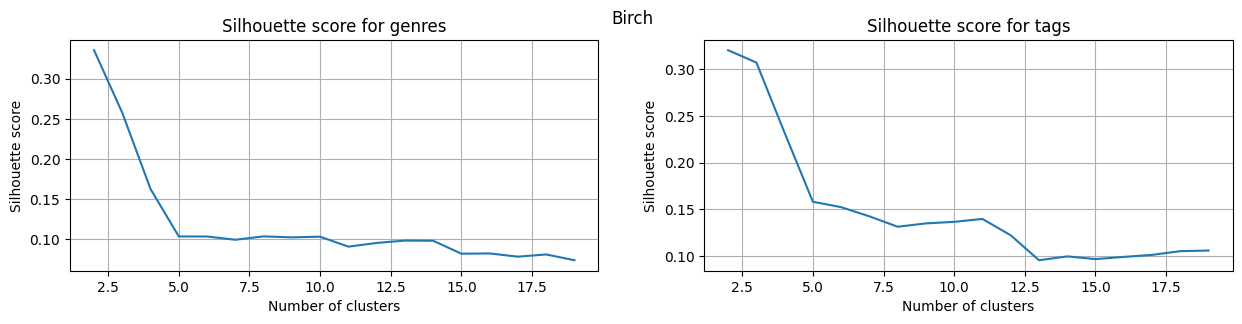

In [72]:
#optimization of K for Birch clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([genre_pca_train,tag_pca_train], Birch,'Birch')

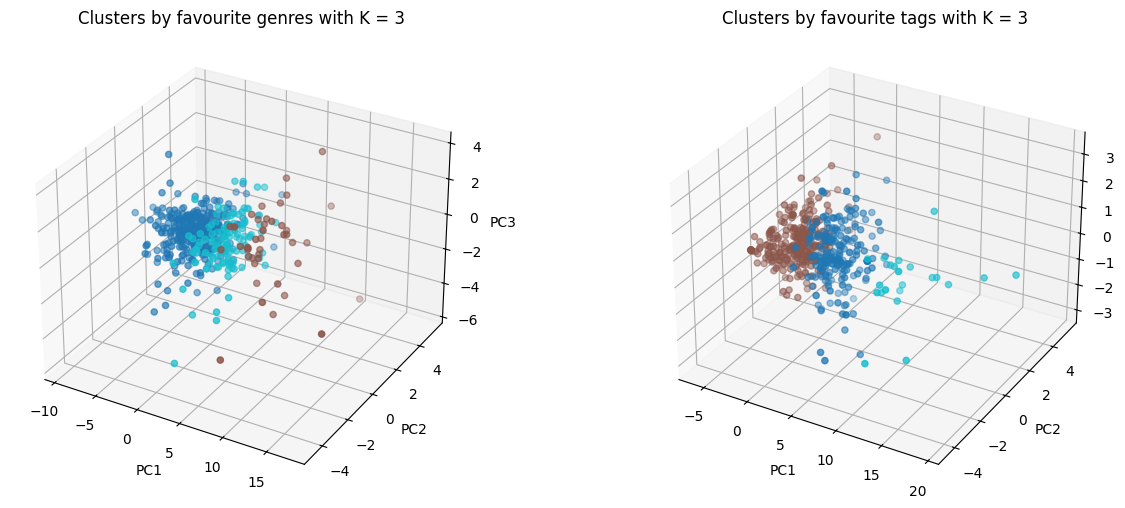

In [73]:
#implementation of Birch clustering by favourite genres
genre_model_birch_pca = Cluster_data(genre_pca_train, genre_k, Birch)

#implementation of Birch clustering by favourite tag
tag_model_birch_pca = Cluster_data(tag_pca_train, tag_K, Birch)

#plot the clusters for first 3 principal components
plot_clusters_3d_pca(genre_pca_train, tag_pca_train, [genre_model_birch_pca,tag_model_birch_pca],genre_k, tag_K)

## Mini-Batch K-Means

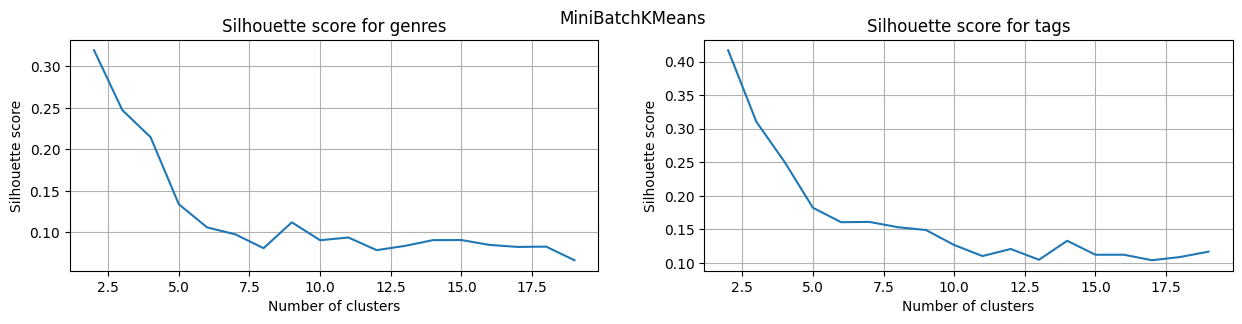

In [74]:
#optimization of K for MiniBatchKMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([genre_pca_train,tag_pca_train], MiniBatchKMeans,'MiniBatchKMeans')

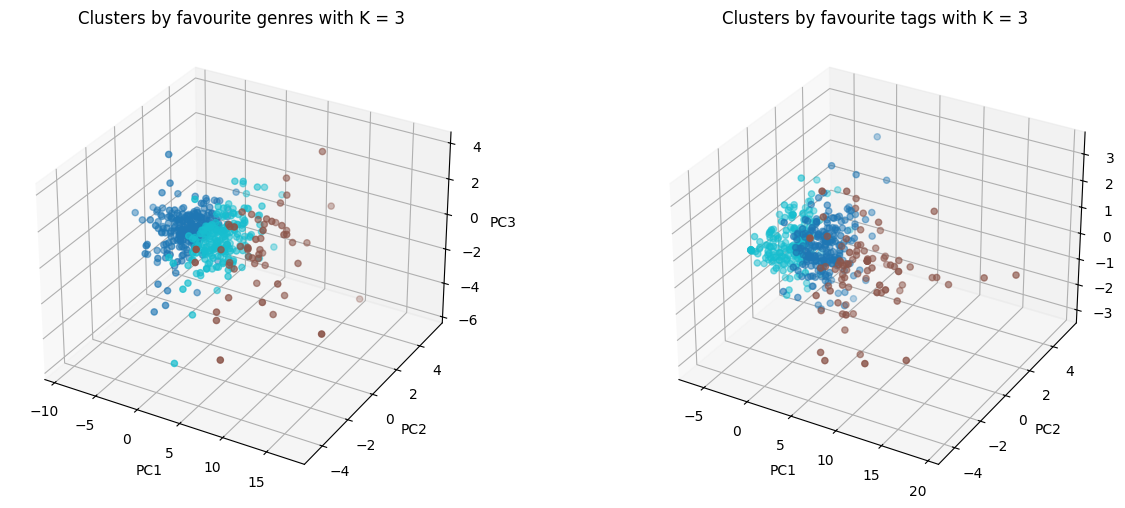

In [75]:
#implementation of MiniBatchKMeans clustering by favourite genres
genre_model_minibatcheskmeans_pca = Cluster_data(genre_pca_train, genre_k, MiniBatchKMeans)

#implementation of MiniBatchKMeans clustering by favourite tags
tag_model_minibatcheskmeans_pca = Cluster_data(tag_pca_train, tag_K, MiniBatchKMeans)

#plot the clusters for first 3 principal components
plot_clusters_3d_pca(genre_pca_train, tag_pca_train, [genre_model_minibatcheskmeans_pca,tag_model_minibatcheskmeans_pca],genre_k, tag_K)

## Mean-Shift

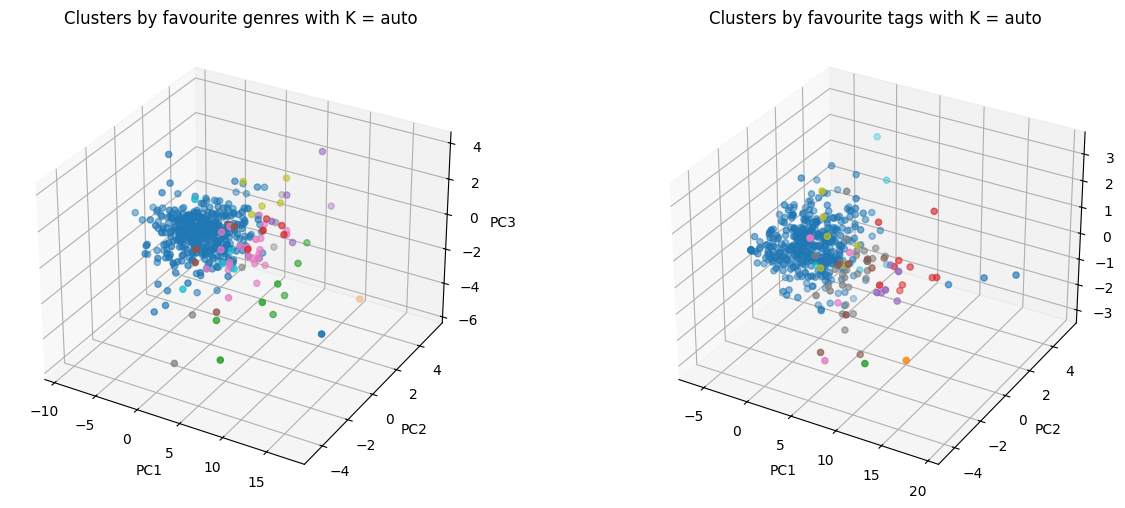

In [76]:
#implementation of MeanShift clustering by favourite genres
genre_model_meanshift_pca = Cluster_data(genre_pca_train, 3, MeanShift)

#implementation of MeanShift clustering by favourite tags
tag_model_meanshift_pca = Cluster_data(tag_pca_train, 3, MeanShift)

#plot the clusters for first 3 principal components
plot_clusters_3d_pca(genre_pca_train, tag_pca_train, [genre_model_meanshift_pca,tag_model_meanshift_pca], 'auto' , 'auto')

## Affinity Propagation

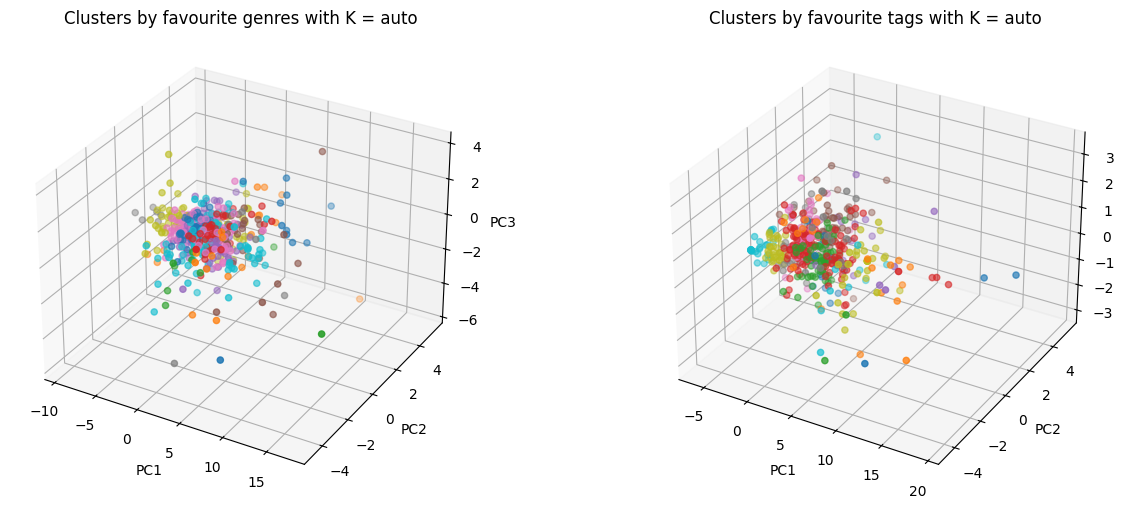

In [98]:
#implementation of AffinityPropagation clustering by favourite genres
genre_model_affinity_pca = Cluster_data(genre_pca_train, 3, AffinityPropagation)

#implementation of AffinityPropagation clustering by favourite tags
tag_model_affinity_pca = Cluster_data(tag_pca_train, 7, AffinityPropagation)

#plot the clusters for first 3 principal components
plot_clusters_3d_pca(genre_pca_train, tag_pca_train, [genre_model_affinity_pca,tag_model_affinity_pca], 'auto' , 'auto')

## Agglomerative

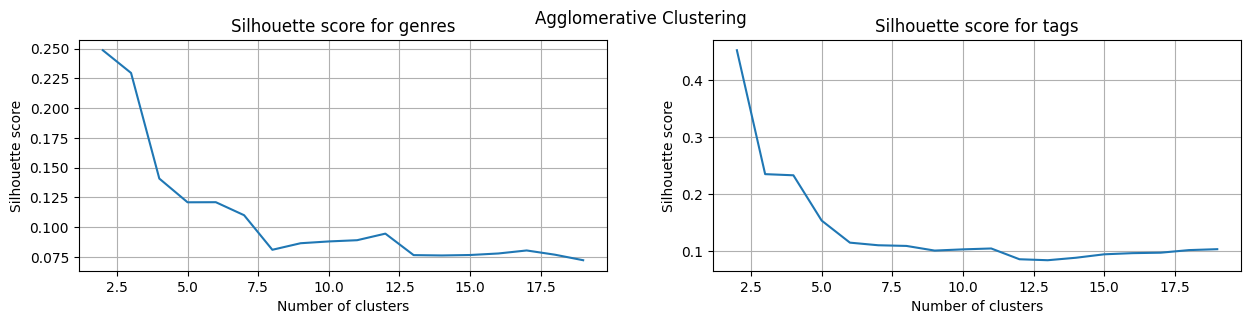

In [78]:
#optimization of K for Agglomerative KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([genre_pca_train,tag_pca_train], AgglomerativeClustering,'Agglomerative Clustering')

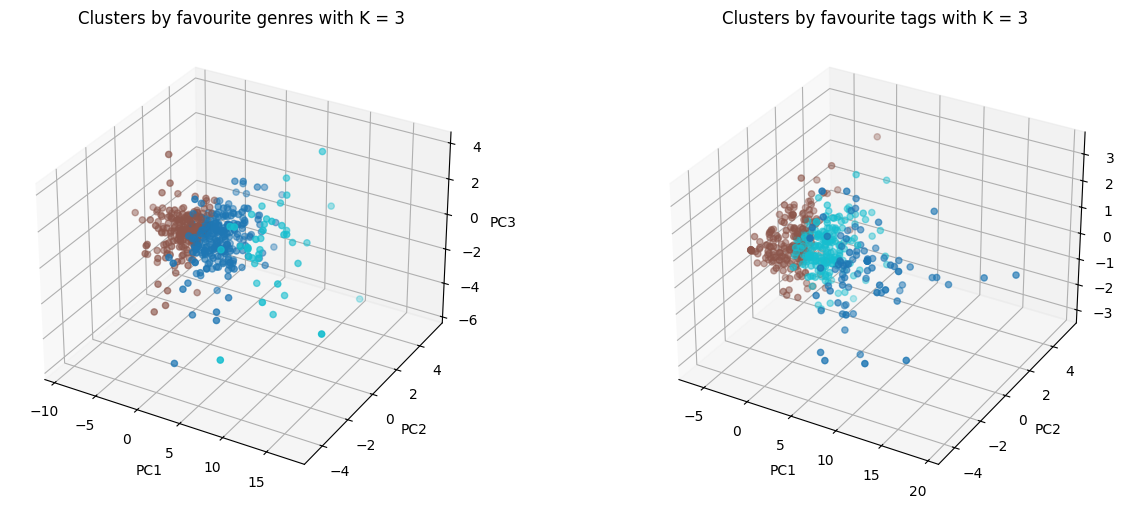

In [79]:
#implementation of AgglomerativeClustering clustering by favourite genres
genre_model_agglomerative_pca = Cluster_data(genre_pca_train, genre_k, AgglomerativeClustering)

#implementation of AgglomerativeClustering clustering by favourite tags
tag_model_agglomerative_pca = Cluster_data(tag_pca_train, tag_K, AgglomerativeClustering)

#plot the clusters for first 3 principal components
plot_clusters_3d_pca(genre_pca_train, tag_pca_train, [genre_model_agglomerative_pca,tag_model_agglomerative_pca], genre_k, tag_K)

## Spectral

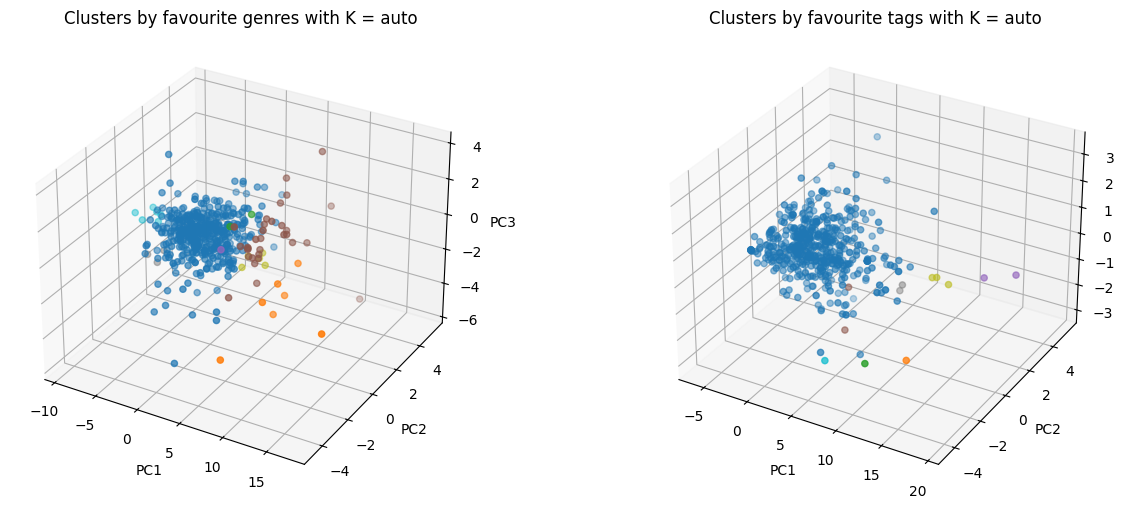

In [80]:
#implementation of SpectralClustering clustering by favourite genres
genre_model_spectral_pca = Cluster_data(genre_pca_train, 3, SpectralClustering)

#implementation of SpectralClustering clustering by favourite tags
tag_model_spectral_pca  = Cluster_data(tag_pca_train, 3, SpectralClustering)

#plot the clusters for first 3 principal components
plot_clusters_3d_pca(genre_pca_train, tag_pca_train, [genre_model_spectral_pca,tag_model_spectral_pca], 'auto', 'auto')

# Evaluation of performance for the 7 clustering models

In [81]:
genre_models = [genre_model_kmean_pca, genre_model_birch_pca, genre_model_minibatcheskmeans_pca, 
                genre_model_meanshift_pca, genre_model_affinity_pca, 
                genre_model_agglomerative_pca, genre_model_spectral_pca]
tag_models = [tag_model_kmean_pca, tag_model_birch_pca, tag_model_minibatcheskmeans_pca
              , tag_model_meanshift_pca, tag_model_affinity_pca, tag_model_agglomerative_pca, tag_model_spectral_pca]
model_names = ['KMeans', 'Birch', 'MiniBatchKMeans', 'MeanShift', 'AffinityPropagation', 'Agglomerative', 'Spectral']

## 1) Clustering Evaluation

### Dunn's Index

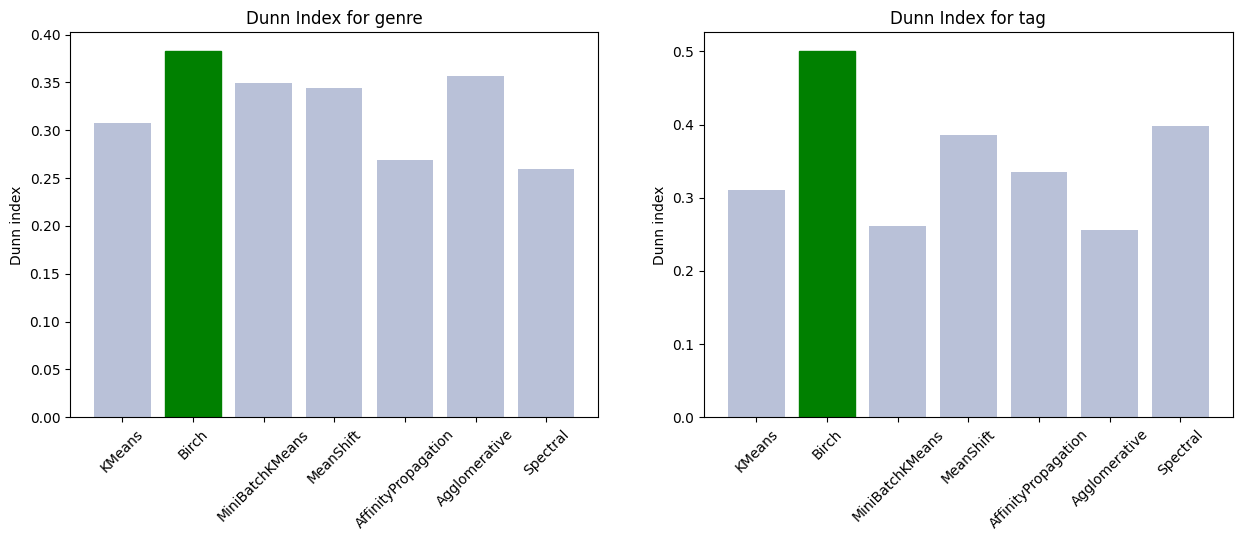

In [82]:
#plot the Dunn index for different clustering models
genre_Dunn_pca = []

for i in range(len(genre_models)):
    genre_Dunn_pca.append(calculate_Dunn_index(genre_pca_train, genre_models[i]))
best_genre = genre_Dunn_pca.index(max(genre_Dunn_pca))

tag_Dunn_pca = []
for i in range(len(tag_models)):
    tag_Dunn_pca.append(calculate_Dunn_index(tag_pca_train, tag_models[i]))
best_tag = tag_Dunn_pca.index(max(tag_Dunn_pca))

plot_results(model_names, genre_Dunn_pca, tag_Dunn_pca, [best_genre, best_tag], 'Dunn Index for', 'Dunn index')

### davies-bouldin index

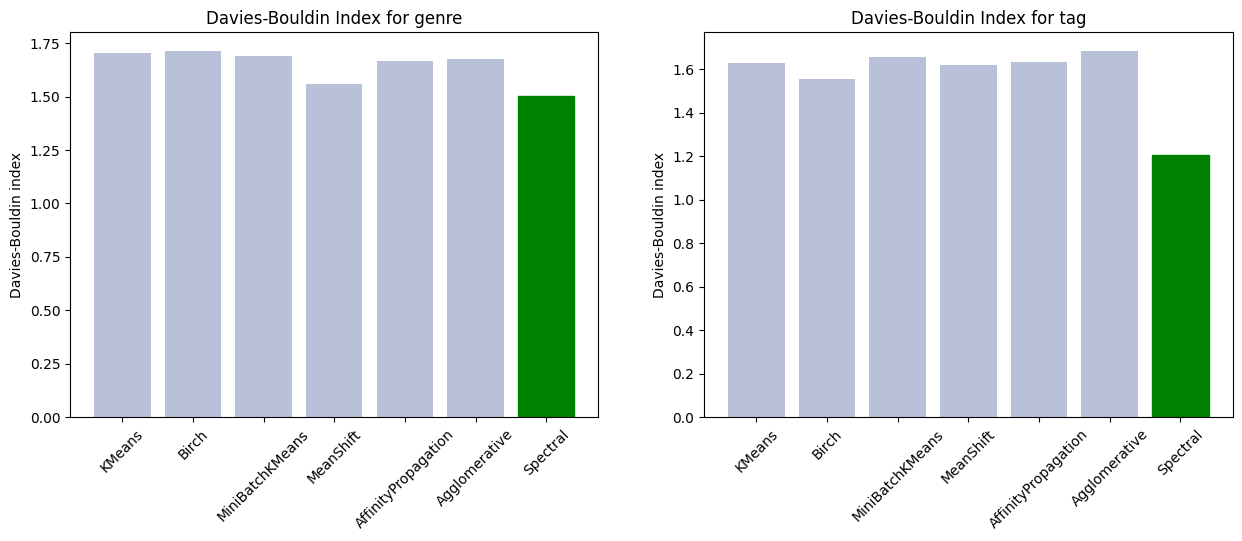

In [83]:
genre_davies_bouldin_pca = []
for i in range(len(genre_models)):
    genre_davies_bouldin_pca.append(davies_bouldin_index(genre_pca_train, genre_models[i]))
best_genre = genre_davies_bouldin_pca.index(min(genre_davies_bouldin_pca))

tag_davies_bouldin_pca = []
for i in range(len(tag_models)):
    tag_davies_bouldin_pca.append(davies_bouldin_index(tag_pca_train, tag_models[i]))
best_tag = tag_davies_bouldin_pca.index(min(tag_davies_bouldin_pca))

plot_results(model_names, genre_davies_bouldin_pca, tag_davies_bouldin_pca, [best_genre, best_tag], 'Davies-Bouldin Index for', 'Davies-Bouldin index')

### calinski-harabasz index

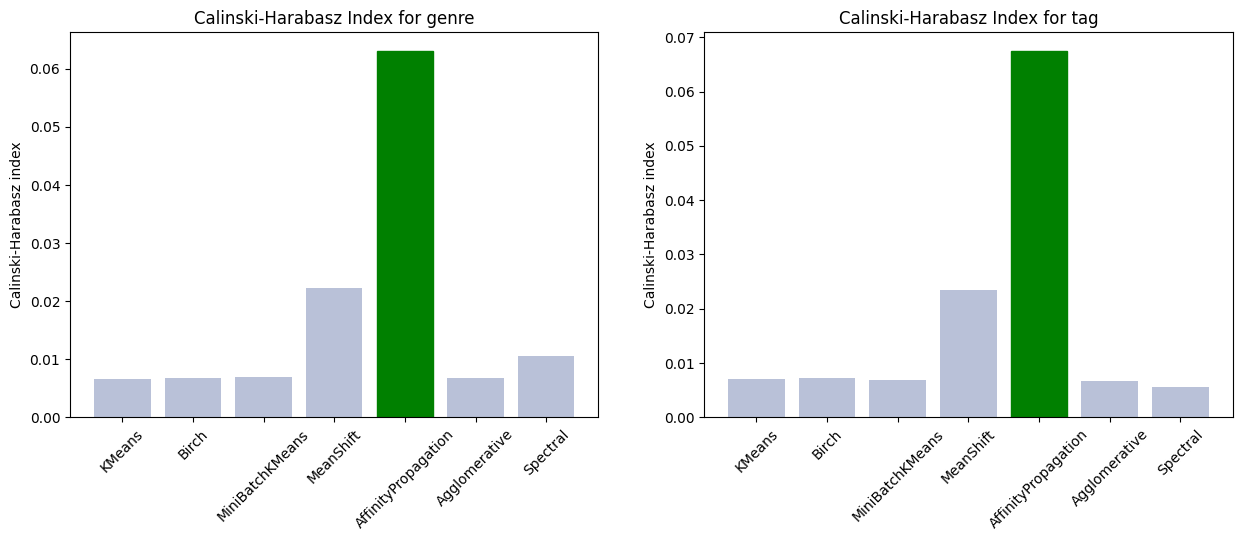

In [84]:
genre_calinski_harabasz_pca = []
for i in range(len(genre_models)):
    genre_calinski_harabasz_pca.append(calinski_harabasz_index(genre_pca_train, genre_models[i]))
best_genre = genre_calinski_harabasz_pca.index(max(genre_calinski_harabasz_pca))

tag_calinski_harabasz_pca = []
for i in range(len(tag_models)):
    tag_calinski_harabasz_pca.append(calinski_harabasz_index(tag_pca_train, tag_models[i]))
best_tag = tag_calinski_harabasz_pca.index(max(tag_calinski_harabasz_pca))

plot_results(model_names, genre_calinski_harabasz_pca, tag_calinski_harabasz_pca, [best_genre, best_tag], 'Calinski-Harabasz Index for', 'Calinski-Harabasz index') 

### Average Similarity

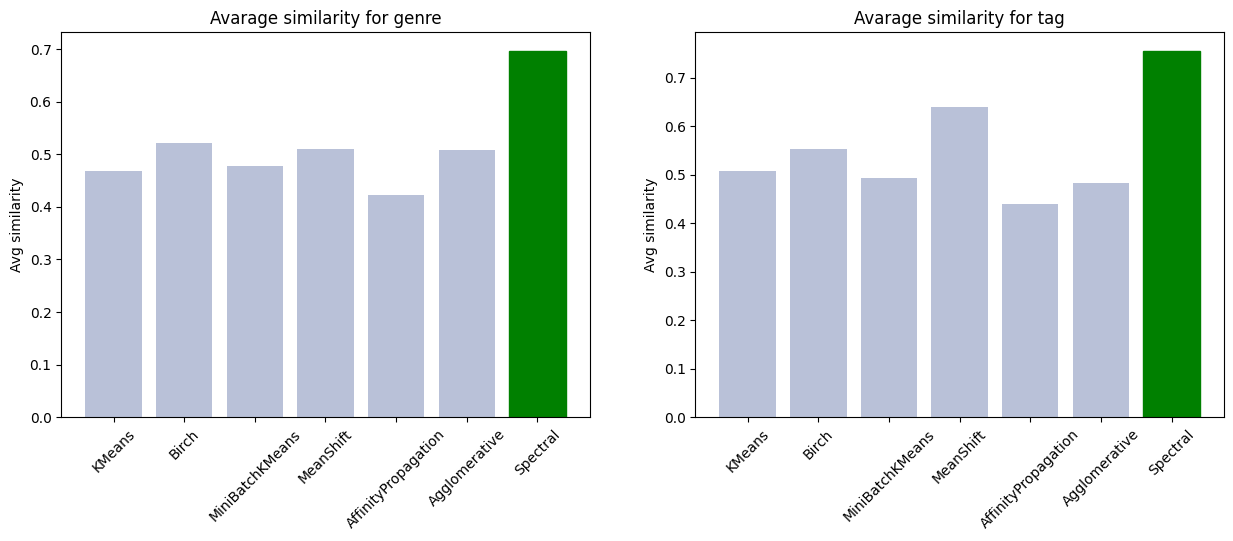

In [85]:
#plot the avarage similarity for different clustering models
genre_similarities = []
for i in range(len(genre_models)):
    genre_similarities.append(average_similarity(genre_pca_train.drop('userId', axis=1).values, genre_models[i]))
best_genre = genre_similarities.index(max(genre_similarities))

tag_similarities = []
for i in range(len(tag_models)):
    tag_similarities.append(average_similarity(tag_pca_train.drop('userId', axis=1).values, tag_models[i]))
best_tag = tag_similarities.index(max(tag_similarities))

plot_results(model_names, genre_similarities, tag_similarities, [best_genre, best_tag], 'Avarage similarity for', 'Avg similarity')

### Computational Time

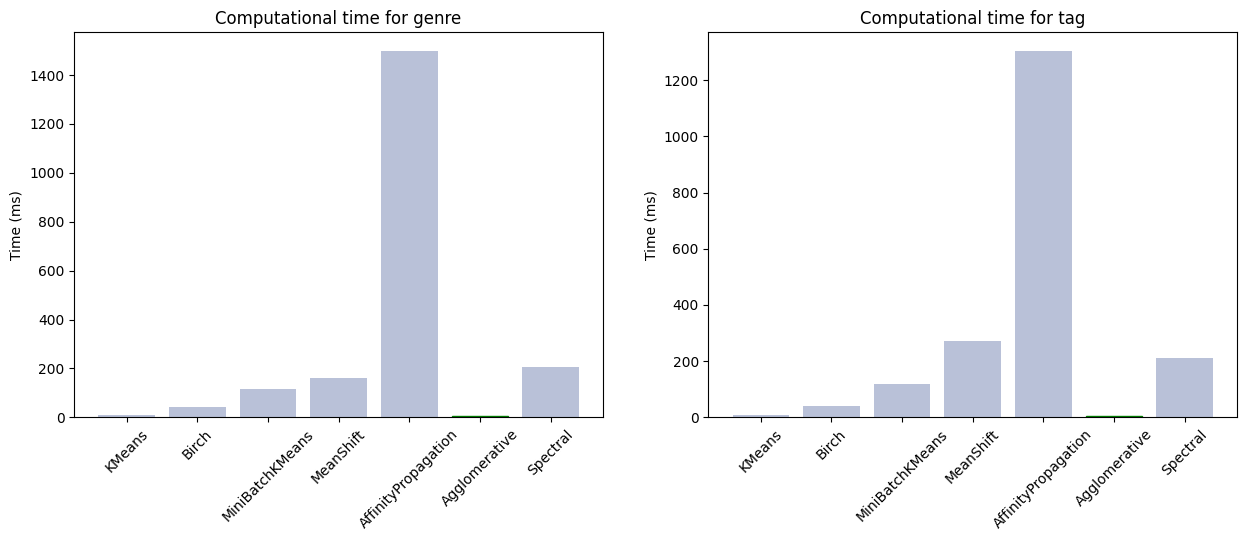

In [86]:
#plot the computational time for different clustering models
genre_results_pca = evaluate_models(genre_pca_train, clustering_methods)
best_genre = genre_results_pca.index(min(genre_results_pca))
tag_results_pca = evaluate_models(tag_pca_train, clustering_methods)
best_tag = tag_results_pca.index(min(tag_results_pca))

plot_results(model_names, genre_results_pca, tag_results_pca, [best_genre, best_tag], 'Computational time for', 'Time (ms)')

## 2) Recommendation System evaluation

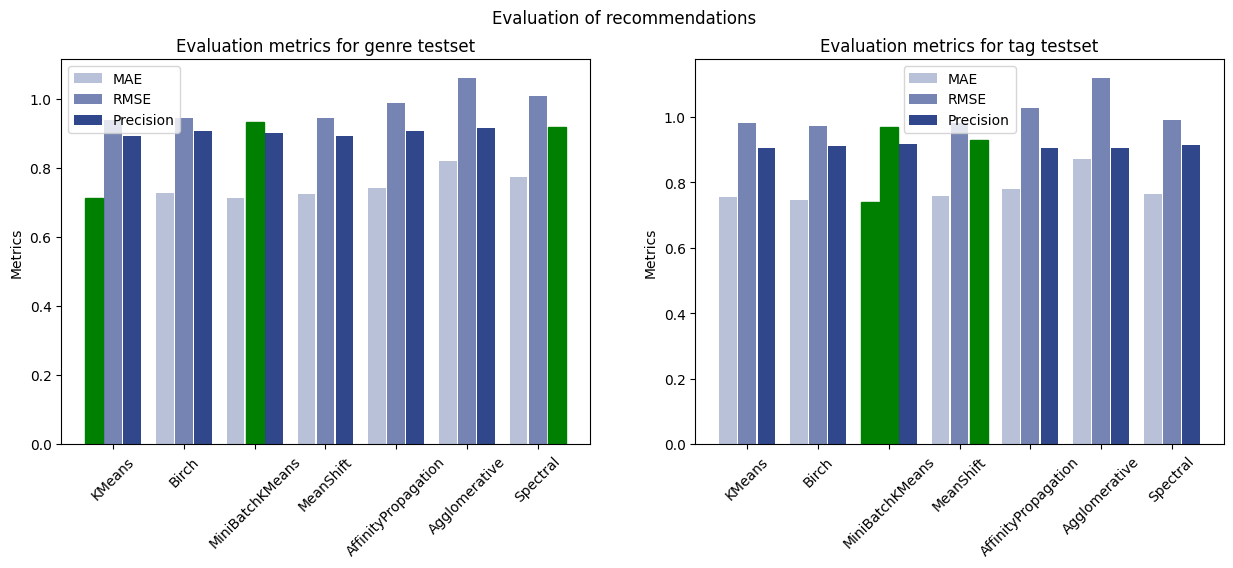

In [87]:
genre_recommender_results_pca = [evaluate_recommender(genre_pca_test, genre_pca_train, 5, genre_models[i], model_names[i]) for i in range(len(genre_models))]
                 
tag_recommender_results_pca = [evaluate_recommender(tag_pca_test, tag_pca_train, 5, tag_models[i], model_names[i]) for i in range(len(genre_models))]

genre_recommender_results_pca = np.array(genre_recommender_results_pca)
tag_recommender_results_pca = np.array(tag_recommender_results_pca)

best_genre_mae = genre_recommender_results_pca[:,0].argmin()
best_genre_rmse = genre_recommender_results_pca[:,1].argmin()
best_genre_precision = genre_recommender_results_pca[:,2].argmax()

best_tag_mae = tag_recommender_results_pca[:,0].argmin()
best_tag_rmse = tag_recommender_results_pca[:,1].argmin()
best_tag_precision = tag_recommender_results_pca[:,2].argmax()

plot_multiple_results(model_names, genre_recommender_results_pca, tag_recommender_results_pca, [best_genre_mae, best_genre_rmse, best_genre_precision],
                        [best_tag_mae, best_tag_rmse, best_tag_precision], 'Evaluation metrics for', 'Metrics')

# Conclusion

Considering the overall performances for different metrics, the best clustering algorithm using movies's genres as clustering dimensions and PCA to reduce dimensionality, is Spectral Clustering, which has the best clustering results and also high recommendations quality 

For tags the result is not so clear, the best clustering algorithm is Spectral Clustering which has good clustering results and decent recommendations quality but Birch Clustering got the highest recommendations score.

# Top N Movies

In [88]:
# example of top 10 recommended movies for a user using birch clustering with movie genres
TOP_N_MOVIES(genre_pca_train, genre_pca_test, genre_model_birch_pca, 609, 20, 'birch')

movieId                                              title
0      4021                          Before Night Falls (2000)
1      5328                                        Rain (2001)
2      5404                       84 Charing Cross Road (1987)
3      6945               My Architect: A Son's Journey (2003)
4      1310                                       Hype! (1996)
5      1904                                  Henry Fool (1997)
6    116897                                  Wild Tales (2014)
7      3224           Woman in the Dunes (Suna no onna) (1964)
8      3223                        Zed & Two Noughts, A (1985)
9      3473  Jonah Who Will Be 25 in the Year 2000 (Jonas q...
10     3475                         Place in the Sun, A (1951)
11   141718                                   Deathgasm (2015)
12    77846                                12 Angry Men (1997)
13     4103                           Empire of the Sun (1987)
14     3341                              Born Yesterday (1950)
15     6159                          All the Real Girls (2003)
16     1809                         Fireworks (Hana-bi) (1997)
17     4617                                 Let It Ride (1989)
18       99               Heidi Fleiss: Hollywood Madam (1995)
19   160644                                 Indignation (2016)

# Comparison of the two strategies

Now I will compare the best clustering algorithms found for the two strategies using the same metrics as before to see if the PCA approach brings substantial improvements or if there isn't any benefit in adopting a more complex method.



In [95]:
results = pd.DataFrame(columns=['Model', 'Silhouette Score', 'Dunn Index' , 'Davies-Bouldin Index', 'Calinski-Harabasz Index', 'Time (ms)', 'MAE', 'RMSE', 'Precision'])

new_row = pd.DataFrame({'Model': 'Birch with 3 genres', 'Silhouette Score': silhouette_score(movies_train.drop('userId', axis=1), genre_model_birch.labels_),
                         'Dunn Index': genre_Dunn[1], 'Davies-Bouldin Index': genre_davies_bouldin[1], 
                         'Calinski-Harabasz Index': genre_calinski_harabasz[1], 'Time (ms)': genre_results[1],
                         'MAE': genre_recommender_results[1,0], 'RMSE': genre_recommender_results[1,1], 
                         'Precision': genre_recommender_results[1,2]}, index=[0])
results = pd.concat([results, new_row])  
new_row = pd.DataFrame({'Model': 'MiniBatchKMeans with 3 tags', 'Silhouette Score': silhouette_score(movies_train.drop('userId', axis=1), genre_model_minibatcheskmeans.labels_),
                         'Dunn Index': genre_Dunn[2], 'Davies-Bouldin Index': genre_davies_bouldin[2],
                           'Calinski-Harabasz Index': genre_calinski_harabasz[2], 'Time (ms)': genre_results[2],
                           'MAE': tag_recommender_results[2,0], 'RMSE': tag_recommender_results[2,1],
                         'Precision': tag_recommender_results[2,2]}, index=[1])
results = pd.concat([results, new_row])
new_row = pd.DataFrame({'Model': 'Spectral Clustering with PCA using genres', 'Silhouette Score': silhouette_score(genre_pca_train.drop('userId', axis=1), genre_model_spectral_pca.labels_),
                         'Dunn Index': genre_Dunn_pca[6], 'Davies-Bouldin Index': genre_davies_bouldin_pca[6],
                           'Calinski-Harabasz Index': genre_calinski_harabasz_pca[6], 'Time (ms)': genre_results_pca[6],
                           'MAE': genre_recommender_results[-1,0], 'RMSE': genre_recommender_results[-1,1],
                         'Precision': genre_recommender_results[-1,2]}, index=[2])
results = pd.concat([results, new_row])
new_row = pd.DataFrame({'Model': 'Birch with PCA using tags', 'Silhouette Score': silhouette_score(tag_pca_train.drop('userId', axis=1), tag_model_birch_pca.labels_),
                         'Dunn Index': tag_Dunn_pca[1], 'Davies-Bouldin Index': tag_davies_bouldin_pca[1],
                           'Calinski-Harabasz Index': tag_calinski_harabasz_pca[1], 'Time (ms)': tag_results_pca[1],
                           'MAE': tag_recommender_results[1,0], 'RMSE': tag_recommender_results[1,1],
                         'Precision': tag_recommender_results[1,2]}, index=[3])
results = pd.concat([results, new_row])

results

Model  Silhouette Score  Dunn Index  \
0                        Birch with 3 genres          0.494244    0.872285   
1                MiniBatchKMeans with 3 tags          0.313762    0.477599   
2  Spectral Clustering with PCA using genres          0.073591    0.259077   
3                  Birch with PCA using tags          0.306971    0.500901   

   Davies-Bouldin Index  Calinski-Harabasz Index   Time (ms)       MAE  \
0              1.291014                 0.011011   10.212183  0.794414   
1              1.561720                 0.015646   10.546207  0.821409   
2              1.502277                 0.010536  206.664324  0.831720   
3              1.553256                 0.007192   41.750193  0.866573   

       RMSE  Precision  
0  1.021977   0.907692  
1  1.059653   0.945455  
2  1.069497   0.888462  
3  1.123112   0.927273

# Final conclusions

As we can see, the two strategies have comparable results for clustering quality, with the first approach having a slight advantage in terms of recommendation quality. 
This results, in addition to the high computational time, the low interpretability and the greater complexity of the Pca approach, makes the first strategy more efficient for building a movie recommender system in this specific settings.

The analysis shows also that choosing movies tags as clustering dimensions provides a slightly worse clustering quality but a better recommendation quality compared to genres.

# TODO 

2 top N movies function fatta bene esterna

4 pulisco codice e aggiungo commenti / sposto funzioni se serve

5 Report